# Project 2: Data Representations and Clustering

In [2]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np


class1 = ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware']
class2 = ['rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']
class_dict = {}
combine_class = set(class1 + class2)
combine_class_dict = {
                        'class1' : [],
                        'class2' : []
                      }
# 'Note that for the clustering sub-tasks, you do not need to separate your data to training and test sets.' (subset='all'?)
combine_class_train = fetch_20newsgroups(subset='train', categories=combine_class, remove=('headers', 'footers'))
for c in combine_class:
    try:
        index = combine_class_train.target_names.index(c)
        class_dict[index] = c
        if c in class1:
            combine_class_dict['class1'].append(index)
        else:
            combine_class_dict['class2'].append(index)
    except ValueError:
        print("Element not found in the list.")

# print(class_dict)
# print(combine_class_dict)

# Step 1: Initialize the TfidfVectorizer with stop words and min_df
vectorizer = TfidfVectorizer(stop_words='english', min_df=3)
combine_class_train_tfidf = vectorizer.fit_transform(combine_class_train.data)
print(combine_class_train_tfidf.shape)
#(4732, 17131)


(4732, 17131)


In [1]:
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, adjusted_rand_score, adjusted_mutual_info_score, homogeneity_score, completeness_score, v_measure_score
from scipy.optimize import linear_sum_assignment
from plotmat import plot_mat

kmeans = KMeans(n_clusters=2, random_state=0, max_iter=1000, n_init=30)
kmeans.fit(combine_class_train_tfidf)
# ground_truth_labels = [combine_class_train.target]
ground_truth_labels = []
for t in combine_class_train.target:
    # class1 ground truth label = 0
    if (t in combine_class_dict['class1']):
        ground_truth_labels.append(0)
    # class2 ground truth label = 1
    else:
        ground_truth_labels.append(1)
# print(set(ground_truth_labels))
kmeans_cluster_labels = kmeans.labels_
# print(set(kmeans_cluster_labels))
# Calculate the contingency table
contingency_matrix = confusion_matrix(ground_truth_labels, kmeans_cluster_labels)

rows, cols = linear_sum_assignment(contingency_matrix, maximize=True)
plot_mat(contingency_matrix[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, size=(15,15))

# Display the contingency table
print("Contingency Table:")
print(contingency_matrix)

# Compute clustering measures
homogeneity = homogeneity_score(ground_truth_labels, kmeans_cluster_labels)
completeness = completeness_score(ground_truth_labels, kmeans_cluster_labels)
v_measure = v_measure_score(ground_truth_labels, kmeans_cluster_labels)
adjusted_rand_index = adjusted_rand_score(ground_truth_labels, kmeans_cluster_labels)
adjusted_mutual_info = adjusted_mutual_info_score(ground_truth_labels, kmeans_cluster_labels)

# Report clustering measures
print("Clustering Measures:")
print(f"Homogeneity: {homogeneity}")
print(f"Completeness: {completeness}")
print(f"V-measure: {v_measure}")
print(f"Adjusted Rand Index: {adjusted_rand_index}")
print(f"Adjusted Mutual Information Score: {adjusted_mutual_info}")

# Contingency Table:
# [[1941  402]
#  [  42 2347]]
# Clustering Measures:
# Homogeneity: 0.5892
# Completeness: 0.6005
# V-measure: 0.5948
# Adjusted Rand Index: 0.6598
# Adjusted Mutual Information Score: 0.5947


ModuleNotFoundError: No module named 'plotmat'

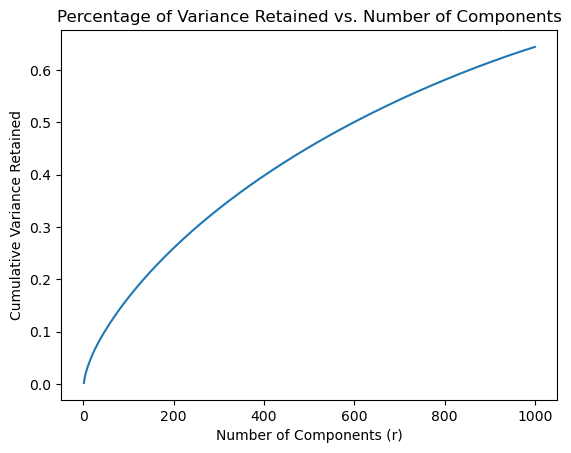

In [4]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import numpy as np
# Number of principal components 'r'
r = 1000 

num_components_range = range(1, r + 1)
# Perform Truncated SVD
svd = TruncatedSVD(n_components=r, random_state=0)
svd.fit(combine_class_train_tfidf)
# print(svd.components_)
# print(svd.singular_values_)
# print(svd.explained_variance_ratio_)

# Perform Truncated SVD for different numbers of components
explained_variance_ratios = []
for r in num_components_range:
    explained_variance_ratios.append(np.sum(svd.explained_variance_ratio_[:r]))
# print(explained_variance_ratios)


# Plot the percentage of variance retained vs. number of components
plt.plot(num_components_range, explained_variance_ratios)
plt.xlabel('Number of Components (r)')
plt.ylabel('Cumulative Variance Retained')
plt.title('Percentage of Variance Retained vs. Number of Components')
plt.show()

In [5]:
from sklearn.decomposition import NMF

r_list = [i for i in range(1,11)] + [20, 50, 100, 300]
# Lists to store measure scores for SVD and NMF
svd_measure_scores = {'ARI': [], 'AMI': [], 'Homogeneity': [], 'Completeness': [], 'V-Measure': []}
nmf_measure_scores = {'ARI': [], 'AMI': [], 'Homogeneity': [], 'Completeness': [], 'V-Measure': []}

for r in r_list:
    # SVD
    svd = TruncatedSVD(n_components=r, random_state=0)
    svd_transformed = svd.fit_transform(combine_class_train_tfidf)
    kmeans_svd = KMeans(n_clusters=2, random_state=0, max_iter=1000, n_init=30)
    kmeans_svd.fit(svd_transformed)
    svd_labels = kmeans_svd.labels_
    # NMF
    nmf = NMF(n_components=r, max_iter=1000, init='random', random_state=0)
    nmf_transformed = nmf.fit_transform(combine_class_train_tfidf)
    kmeans_nmf = KMeans(n_clusters=2, random_state=0, max_iter=1000, n_init=30)
    kmeans_nmf.fit(nmf_transformed)
    nmf_labels = kmeans_nmf.labels_

    # Calculate measure scores
    svd_measure_scores['ARI'].append(adjusted_rand_score(ground_truth_labels, svd_labels))
    svd_measure_scores['AMI'].append(adjusted_mutual_info_score(ground_truth_labels, svd_labels))
    svd_measure_scores['Homogeneity'].append(homogeneity_score(ground_truth_labels, svd_labels))
    svd_measure_scores['Completeness'].append(completeness_score(ground_truth_labels, svd_labels))
    svd_measure_scores['V-Measure'].append(v_measure_score(ground_truth_labels, svd_labels))

    nmf_measure_scores['ARI'].append(adjusted_rand_score(ground_truth_labels, nmf_labels))
    nmf_measure_scores['AMI'].append(adjusted_mutual_info_score(ground_truth_labels, nmf_labels))
    nmf_measure_scores['Homogeneity'].append(homogeneity_score(ground_truth_labels, nmf_labels))
    nmf_measure_scores['Completeness'].append(completeness_score(ground_truth_labels, nmf_labels))
    nmf_measure_scores['V-Measure'].append(v_measure_score(ground_truth_labels, nmf_labels))
    

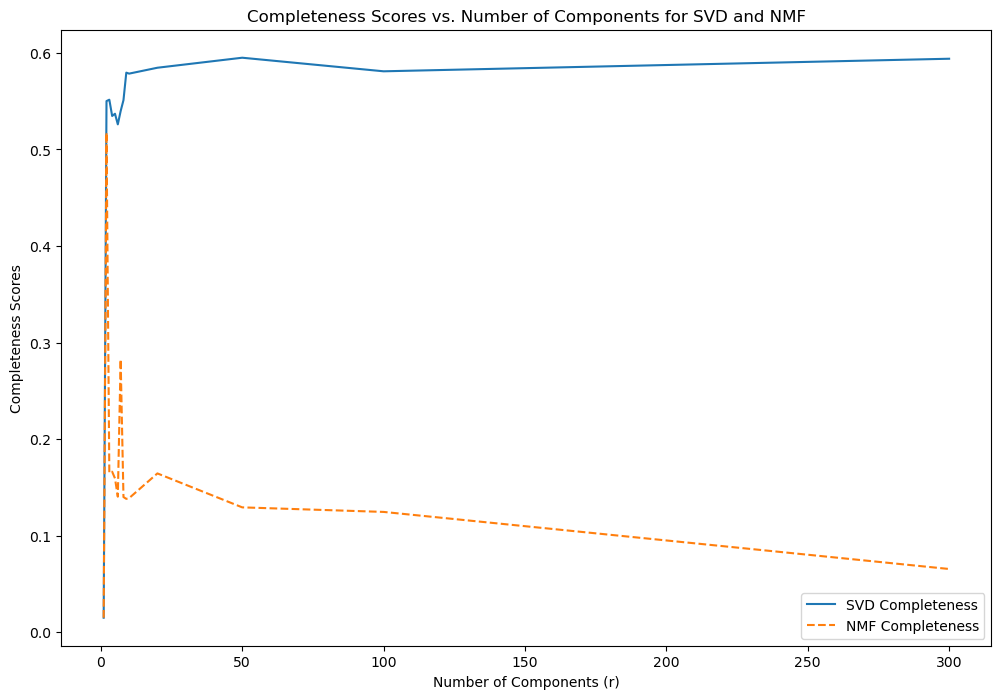

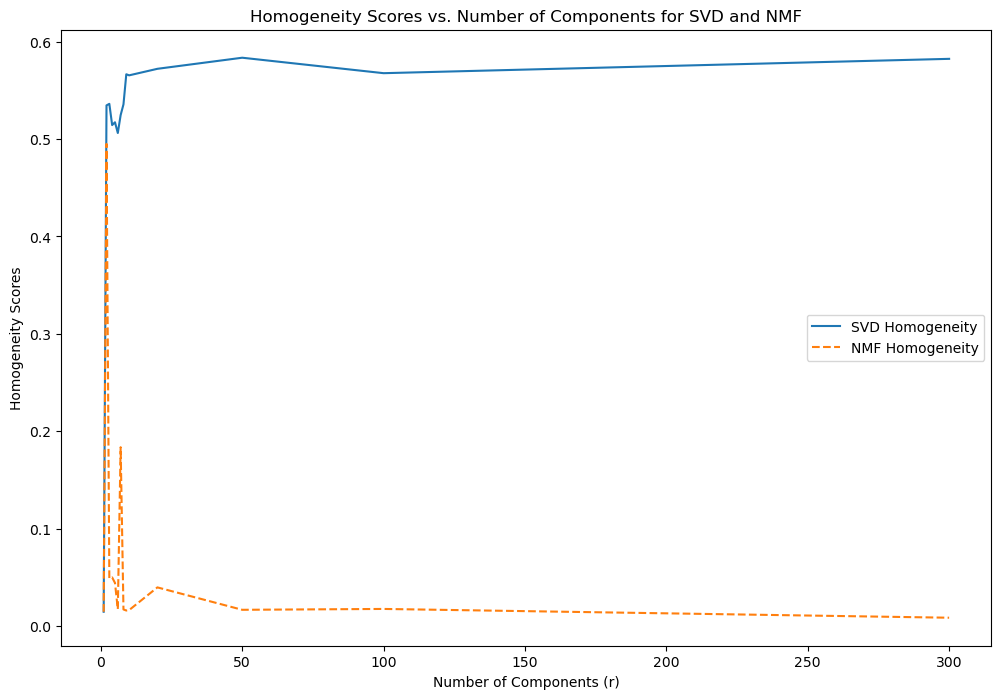

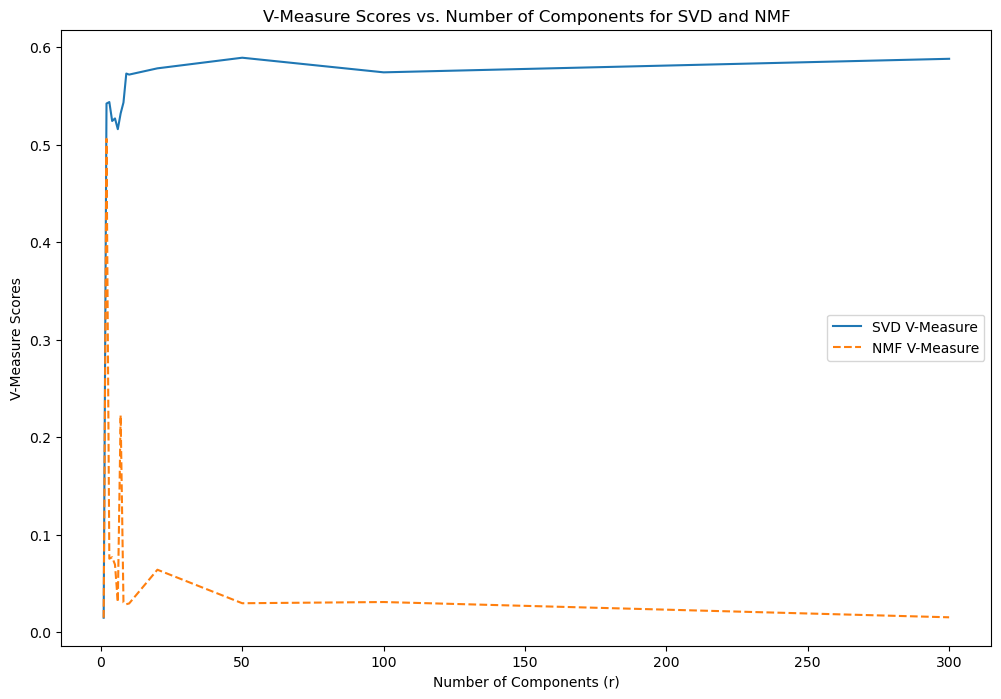

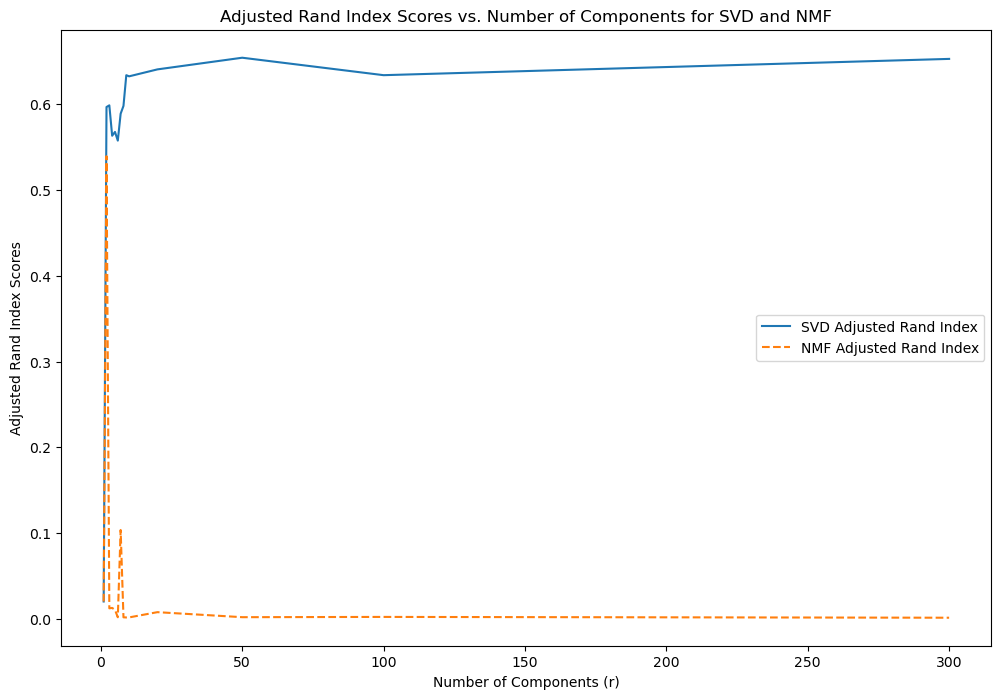

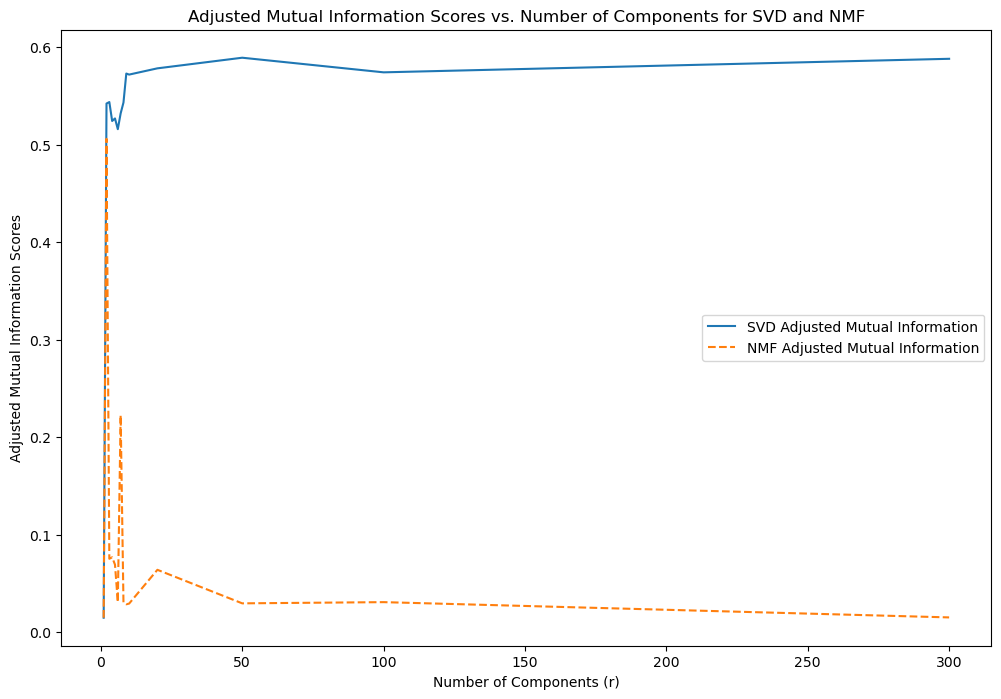

In [6]:
# Plot the measure scores vs. r for both SVD and NMF

# Comparing SVD and NMF completeness scores:
plt.figure(figsize=(12, 8))
plt.plot(r_list, svd_measure_scores.get('Completeness'), label=f'SVD Completeness')
plt.plot(r_list, nmf_measure_scores.get('Completeness'), label=f'NMF Completeness', linestyle='dashed')
plt.xlabel('Number of Components (r)')
plt.ylabel('Completeness Scores')
plt.title('Completeness Scores vs. Number of Components for SVD and NMF')
plt.legend()

# Comparing SVD and NMF homogeneity scores:
plt.figure(figsize=(12, 8))
plt.plot(r_list, svd_measure_scores.get('Homogeneity'), label=f'SVD Homogeneity')
plt.plot(r_list, nmf_measure_scores.get('Homogeneity'), label=f'NMF Homogeneity', linestyle='dashed')
plt.xlabel('Number of Components (r)')
plt.ylabel('Homogeneity Scores')
plt.title('Homogeneity Scores vs. Number of Components for SVD and NMF')
plt.legend()

# Comparing SVD and NMF v-measure scores:
plt.figure(figsize=(12, 8))
plt.plot(r_list, svd_measure_scores.get('V-Measure'), label=f'SVD V-Measure')
plt.plot(r_list, nmf_measure_scores.get('V-Measure'), label=f'NMF V-Measure', linestyle='dashed')
plt.xlabel('Number of Components (r)')
plt.ylabel('V-Measure Scores')
plt.title('V-Measure Scores vs. Number of Components for SVD and NMF')
plt.legend()

# Comparing SVD and NMF adjusted rand index scores:
plt.figure(figsize=(12, 8))
plt.plot(r_list, svd_measure_scores.get('ARI'), label=f'SVD Adjusted Rand Index')
plt.plot(r_list, nmf_measure_scores.get('ARI'), label=f'NMF Adjusted Rand Index', linestyle='dashed')
plt.xlabel('Number of Components (r)')
plt.ylabel('Adjusted Rand Index Scores')
plt.title('Adjusted Rand Index Scores vs. Number of Components for SVD and NMF')
plt.legend()

# Comparing SVD and NMF adjusted mutual information scores:
plt.figure(figsize=(12, 8))
plt.plot(r_list, svd_measure_scores.get('AMI'), label=f'SVD Adjusted Mutual Information')
plt.plot(r_list, nmf_measure_scores.get('AMI'), label=f'NMF Adjusted Mutual Information', linestyle='dashed')
plt.xlabel('Number of Components (r)')
plt.ylabel('Adjusted Mutual Information Scores')
plt.title('Adjusted Mutual Information Scores vs. Number of Components for SVD and NMF')
plt.legend()
    

In [7]:
# Finding the r with the best measured scores for svd

for k in svd_measure_scores:
    print(f'SVD {k} scores : {svd_measure_scores[k]}')

print()

# Finding the r with the best completeness score
best_svd_completeness_score = max(svd_measure_scores['Completeness'])
try:
    best_svd_completeness_score_index = svd_measure_scores['Completeness'].index(best_svd_completeness_score)
except ValueError:
    print("Element not found in the list.")
best_svd_completeness_score_r = r_list[best_svd_completeness_score_index]

print("Best svd completeness score: ", best_svd_completeness_score)
print("Best svd completeness score 'r': ", best_svd_completeness_score_r)
print()

# Finding the r with the best homogeneity score
best_svd_homogeneity_score = max(svd_measure_scores['Homogeneity'])
try:
    best_svd_homogeneity_score_index = svd_measure_scores['Homogeneity'].index(best_svd_homogeneity_score)
except ValueError:
    print("Element not found in the list.")
best_svd_homogeneity_score_r = r_list[best_svd_homogeneity_score_index]

print("Best svd homogeneity score: ", best_svd_homogeneity_score)
print("Best svd homogeneity score 'r': ", best_svd_homogeneity_score_r)
print()

# Finding the r with the best V-Measure score
best_svd_v_measure_score = max(svd_measure_scores['V-Measure'])
try:
    best_svd_v_measure_score_index = svd_measure_scores['V-Measure'].index(best_svd_v_measure_score)
except ValueError:
    print("Element not found in the list.")
best_svd_v_measure_score_r = r_list[best_svd_v_measure_score_index]

print("Best svd V-Measure score: ", best_svd_v_measure_score)
print("Best svd V-Measure score 'r': ", best_svd_v_measure_score_r)
print()

# Finding the r with the best Adjusted Rand Index score
best_svd_ari_score = max(svd_measure_scores['ARI'])
try:
    best_svd_ari_score_index = svd_measure_scores['ARI'].index(best_svd_ari_score)
except ValueError:
    print("Element not found in the list.")
best_svd_ari_score_r = r_list[best_svd_ari_score_index]

print("Best svd Adjusted Rand Index score: ", best_svd_ari_score)
print("Best svd Adjusted Rand Index score 'r': ", best_svd_ari_score_r)
print()

# Finding the r with the best Adjusted Mutual Information score
best_svd_ami_score = max(svd_measure_scores['AMI'])
try:
    best_svd_ami_score_index = svd_measure_scores['AMI'].index(best_svd_ami_score)
except ValueError:
    print("Element not found in the list.")
best_svd_ami_score_r = r_list[best_svd_ami_score_index]

print("Best svd Adjusted Mutual Information score: ", best_svd_ami_score)
print("Best svd Adjusted Mutual Information score 'r': ", best_svd_ami_score_r)


SVD ARI scores : [0.02020303421124531, 0.5968459357552031, 0.5988072122535917, 0.5633617573840933, 0.5678129582242651, 0.5576643718999716, 0.589032881431979, 0.5981530960314251, 0.6339868325181948, 0.6326410746918547, 0.6407370648125658, 0.6543447450018023, 0.633986858133615, 0.6529775440581369]
SVD AMI scores : [0.014704506033838053, 0.5421272600012061, 0.5436321625400072, 0.5242244136530347, 0.5268192739762259, 0.5158095564400494, 0.5319593684795653, 0.5431299894341965, 0.5728720856649366, 0.5718097886878958, 0.5782207773782718, 0.5891097604108302, 0.5741191402407878, 0.588009063671745]
SVD Homogeneity scores : [0.014764540730770699, 0.5345471596784493, 0.5361297238370345, 0.5143407056921523, 0.5172194936648734, 0.5061964586194773, 0.5245890341406007, 0.535601682975188, 0.5665044387305193, 0.5653919760069048, 0.5721024134222689, 0.5834818461592091, 0.5676119789802915, 0.5823326120356693]
SVD Completeness scores : [0.014947974508587522, 0.5500712061697123, 0.5514927694347858, 0.534649

In [8]:
# Finding the r with the best measured scores for nmf

for k in nmf_measure_scores:
    print(f'NMF {k} scores : {nmf_measure_scores[k]}')

print()

# Finding the r with the best completeness score
best_nmf_completeness_score = max(nmf_measure_scores['Completeness'])
try:
    best_nmf_completeness_score_index = nmf_measure_scores['Completeness'].index(best_nmf_completeness_score)
except ValueError:
    print("Element not found in the list.")
best_nmf_completeness_score_r = r_list[best_nmf_completeness_score_index]

print("Best nmf completeness score: ", best_nmf_completeness_score)
print("Best nmf completeness score 'r': ", best_nmf_completeness_score_r)
print()

# Finding the r with the best homogeneity score
best_nmf_homogeneity_score = max(nmf_measure_scores['Homogeneity'])
try:
    best_nmf_homogeneity_score_index = nmf_measure_scores['Homogeneity'].index(best_nmf_homogeneity_score)
except ValueError:
    print("Element not found in the list.")
best_nmf_homogeneity_score_r = r_list[best_nmf_homogeneity_score_index]

print("Best nmf homogeneity score: ", best_nmf_homogeneity_score)
print("Best nmf homogeneity score 'r': ", best_nmf_homogeneity_score_r)
print()

# Finding the r with the best V-Measure score
best_nmf_v_measure_score = max(nmf_measure_scores['V-Measure'])
try:
    best_nmf_v_measure_score_index = nmf_measure_scores['V-Measure'].index(best_nmf_v_measure_score)
except ValueError:
    print("Element not found in the list.")
best_nmf_v_measure_score_r = r_list[best_nmf_v_measure_score_index]

print("Best nmf V-Measure score: ", best_nmf_v_measure_score)
print("Best nmf V-Measure score 'r': ", best_nmf_v_measure_score_r)
print()

# Finding the r with the best Adjusted Rand Index score
best_nmf_ari_score = max(nmf_measure_scores['ARI'])
try:
    best_nmf_ari_score_index = nmf_measure_scores['ARI'].index(best_nmf_ari_score)
except ValueError:
    print("Element not found in the list.")
best_nmf_ari_score_r = r_list[best_nmf_ari_score_index]

print("Best nmf Adjusted Rand Index score: ", best_nmf_ari_score)
print("Best nmf Adjusted Rand Index score 'r': ", best_nmf_ari_score_r)
print()

# Finding the r with the best Adjusted Mutual Information score
best_nmf_ami_score = max(nmf_measure_scores['AMI'])
try:
    best_nmf_ami_score_index = nmf_measure_scores['AMI'].index(best_nmf_ami_score)
except ValueError:
    print("Element not found in the list.")
best_nmf_ami_score_r = r_list[best_nmf_ami_score_index]

print("Best nmf Adjusted Mutual Information score: ", best_nmf_ami_score)
print("Best nmf Adjusted Mutual Information score 'r': ", best_nmf_ami_score_r)


NMF ARI scores : [0.02020303421124531, 0.5395035409494571, 0.012239846302024102, 0.012713746360577946, 0.010433589255848726, 0.001793072057173281, 0.1035813637671879, 0.0017565431023136725, 0.0015792587019122658, 0.0016491003876853985, 0.007766326570365113, 0.0019046128764511315, 0.0022180974680020647, 0.0012805595142241367]
NMF AMI scores : [0.014704506033838053, 0.505915879956075, 0.07518782352522996, 0.07667678300374191, 0.06918580793628996, 0.030632140476103496, 0.22245125338255106, 0.030274459291628555, 0.028477498980167132, 0.029198012092532897, 0.06385083925300322, 0.029446910017396636, 0.03068674921413104, 0.015020314282733562]
NMF Homogeneity scores : [0.014764540730770699, 0.4950453839087971, 0.048884193081306405, 0.050017803105150076, 0.044374259493567055, 0.017359487145696097, 0.18366651295840725, 0.01713980800066788, 0.016042448556356836, 0.016481185259195962, 0.03979566013984849, 0.016784186603637473, 0.017668810610061904, 0.008654682048534456]
NMF Completeness scores : [

In [9]:
best_svd_r = 50
best_nmf_r = 2

try:
    best_svd_r_index = r_list.index(best_svd_r)
except ValueError:
    print("Element not found in the list.")

# Compute clustering measures
svd_with_best_r_homogeneity = svd_measure_scores['Homogeneity'][best_svd_r_index]
svd_with_best_r_completeness = svd_measure_scores['Completeness'][best_svd_r_index]
svd_with_best_r_v_measure = svd_measure_scores['V-Measure'][best_svd_r_index]
svd_with_best_r_adjusted_rand_index = svd_measure_scores['ARI'][best_svd_r_index]
svd_with_best_r_adjusted_mutual_info = svd_measure_scores['AMI'][best_svd_r_index]

# Report clustering measures
print(f"SVD with the Optimal 'r' (r = {best_svd_r}) Clustering Measures:")
print(f"Homogeneity: {svd_with_best_r_homogeneity}")
print(f"Completeness: {svd_with_best_r_completeness}")
print(f"V-measure: {svd_with_best_r_v_measure}")
print(f"Adjusted Rand Index: {svd_with_best_r_adjusted_rand_index}")
print(f"Adjusted Mutual Information Score: {svd_with_best_r_adjusted_mutual_info}")
print()

try:
    best_nmf_r_index = r_list.index(best_nmf_r)
except ValueError:
    print("Element not found in the list.")

# Compute clustering measures
nmf_with_best_r_homogeneity = nmf_measure_scores['Homogeneity'][best_nmf_r_index]
nmf_with_best_r_completeness = nmf_measure_scores['Completeness'][best_nmf_r_index]
nmf_with_best_r_v_measure = nmf_measure_scores['V-Measure'][best_nmf_r_index]
nmf_with_best_r_adjusted_rand_index = nmf_measure_scores['ARI'][best_nmf_r_index]
nmf_with_best_r_adjusted_mutual_info = nmf_measure_scores['AMI'][best_nmf_r_index]

# Report clustering measures
print(f"NMF with the Optimal 'r' (r = {best_nmf_r}) Clustering Measures:")
print(f"Homogeneity: {nmf_with_best_r_homogeneity}")
print(f"Completeness: {nmf_with_best_r_completeness}")
print(f"V-measure: {nmf_with_best_r_v_measure}")
print(f"Adjusted Rand Index: {nmf_with_best_r_adjusted_rand_index}")
print(f"Adjusted Mutual Information Score: {nmf_with_best_r_adjusted_mutual_info}")

SVD with the Optimal 'r' (r = 50) Clustering Measures:
Homogeneity: 0.5834818461592091
Completeness: 0.5949763345928967
V-measure: 0.5891730326955555
Adjusted Rand Index: 0.6543447450018023
Adjusted Mutual Information Score: 0.5891097604108302

NMF with the Optimal 'r' (r = 2) Clustering Measures:
Homogeneity: 0.4950453839087971
Completeness: 0.5174355469228464
V-measure: 0.5059928956174533
Adjusted Rand Index: 0.5395035409494571
Adjusted Mutual Information Score: 0.505915879956075


In [10]:
# Finding the average measured scores for SVD
for k in svd_measure_scores:
    print(f'SVD {k} mean scores : {np.mean(svd_measure_scores[k])}')

print()

# Finding the average measured scores for NMF
for k in nmf_measure_scores:
    print(f'NMF {k} mean scores : {np.mean(nmf_measure_scores[k])}')


# Clustering Measures from Question 3
# Homogeneity: 0.5892
# Completeness: 0.6005
# V-measure: 0.5948
# Adjusted Rand Index: 0.6598
# Adjusted Mutual Information Score: 0.5947

SVD ARI mean scores : 0.567182526171996
SVD AMI mean scores : 0.5154676533294708
SVD Homogeneity mean scores : 0.5086295760481007
SVD Completeness mean scores : 0.5226573391383235
SVD V-Measure mean scores : 0.515542491271773

NMF ARI mean scores : 0.051330192251747724
NMF AMI mean scores : 0.08726492696038732
NMF Homogeneity mean scores : 0.0704770686887141
NMF Completeness mean scores : 0.16756615651774417
NMF V-Measure mean scores : 0.08748731407893089


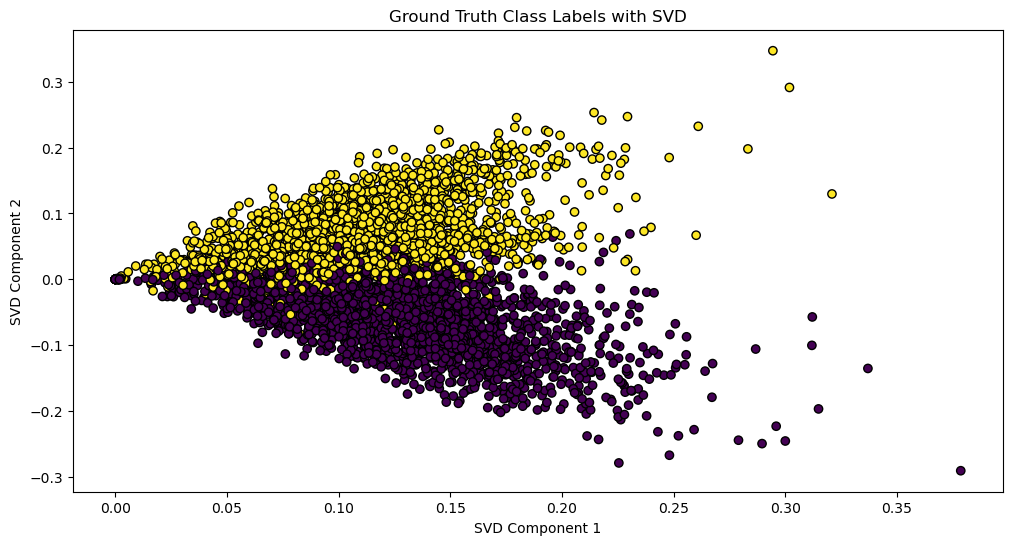

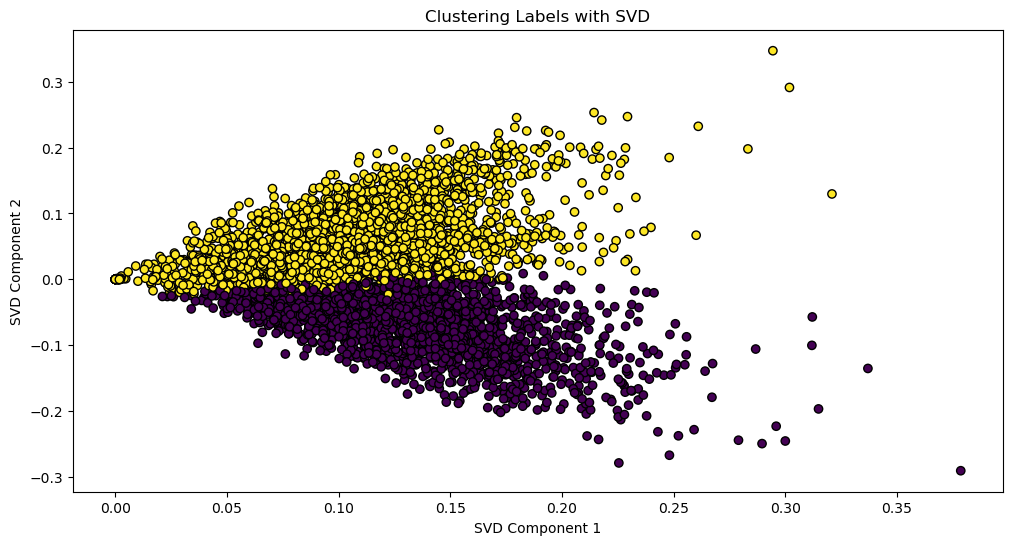

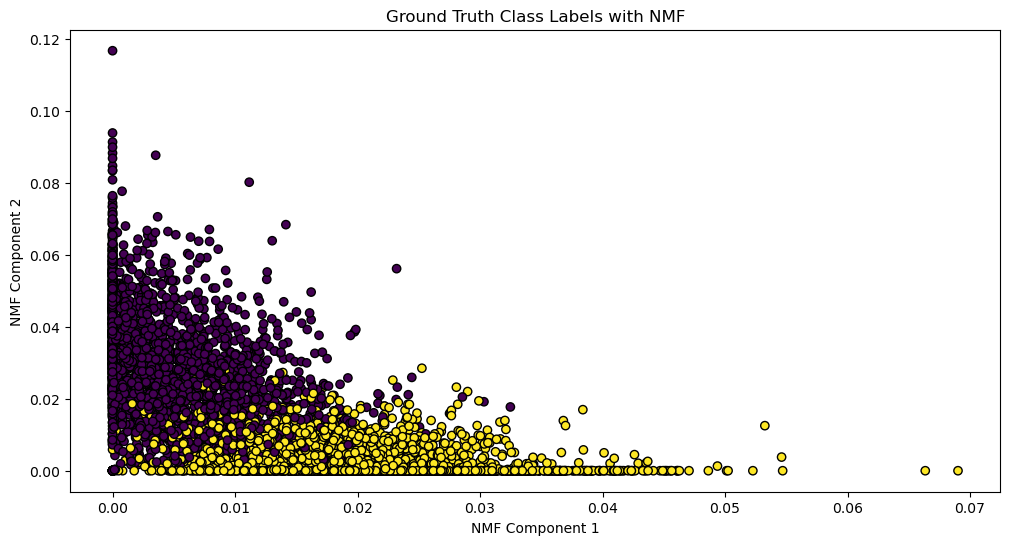

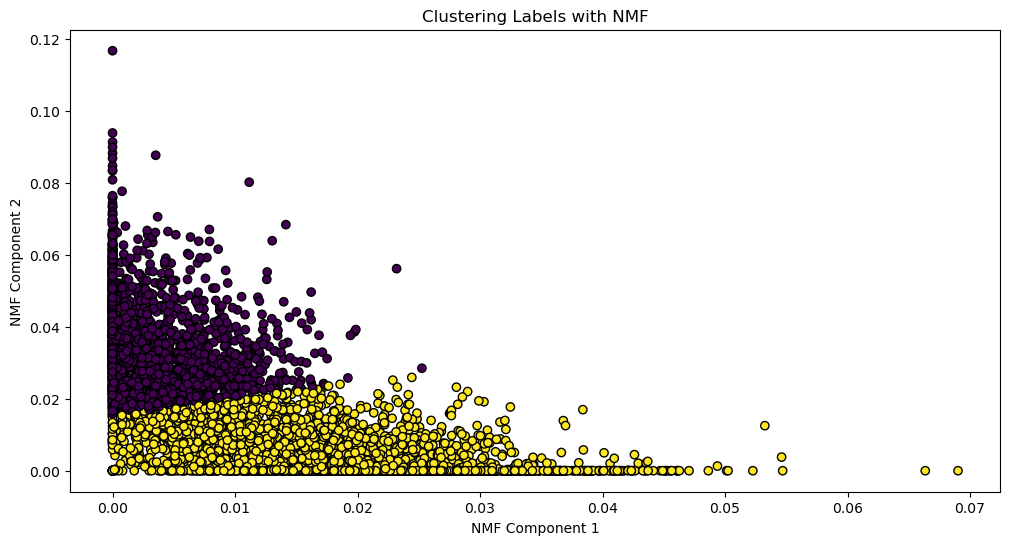

In [11]:
svd = TruncatedSVD(n_components=best_svd_r, random_state=0)
svd_transformed = svd.fit_transform(combine_class_train_tfidf)
kmeans_svd = KMeans(n_clusters=2, random_state=0, max_iter=1000, n_init=30)
kmeans_svd.fit(svd_transformed)
svd_labels = kmeans_svd.labels_

# Visualize SVD clustering results
plt.figure(figsize=(12, 6))
plt.scatter(svd_transformed[:, 0], svd_transformed[:, 1], c=ground_truth_labels, cmap='viridis', edgecolors='k')
plt.title('Ground Truth Class Labels with SVD')
plt.xlabel('SVD Component 1')
plt.ylabel('SVD Component 2')
plt.show()

# Visualize clustering results
plt.figure(figsize=(12, 6))
plt.scatter(svd_transformed[:, 0], svd_transformed[:, 1], c=svd_labels, cmap='viridis', edgecolors='k')
plt.title('Clustering Labels with SVD')
plt.xlabel('SVD Component 1')
plt.ylabel('SVD Component 2')
plt.show()

nmf = NMF(n_components=best_nmf_r, max_iter=1000, init='random', random_state=0)
nmf_transformed = nmf.fit_transform(combine_class_train_tfidf)
kmeans_nmf = KMeans(n_clusters=2, random_state=0, max_iter=1000, n_init=30)
kmeans_nmf.fit(nmf_transformed)
nmf_labels = kmeans_nmf.labels_

plt.figure(figsize=(12, 6))
plt.scatter(nmf_transformed[:, 0], nmf_transformed[:, 1], c=ground_truth_labels, cmap='viridis', edgecolors='k')
plt.title('Ground Truth Class Labels with NMF')
plt.xlabel('NMF Component 1')
plt.ylabel('NMF Component 2')
plt.show()

# Visualize clustering results
plt.figure(figsize=(12, 6))
plt.scatter(nmf_transformed[:, 0], nmf_transformed[:, 1], c=nmf_labels, cmap='viridis', edgecolors='k')
plt.title('Clustering Labels with NMF')
plt.xlabel('NMF Component 1')
plt.ylabel('NMF Component 2')
plt.show()


In [12]:
newsgroup20_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers'))
newsgroup20_ground_truth_labels = newsgroup20_train.target
# print(newsgroup20_train.target_names)
# print(len(newsgroup20_train.target_names))
vectorizer = TfidfVectorizer(stop_words='english', min_df=3)
newsgroup20_train_tfidf = vectorizer.fit_transform(newsgroup20_train.data)
# print(newsgroup20_train_tfidf.shape)

newsgroup20_svd_measure_scores = {'ARI': [], 'AMI': [], 'Homogeneity': [], 'Completeness': [], 'V-Measure': []}
newsgroup20_nmf_measure_scores = {'ARI': [], 'AMI': [], 'Homogeneity': [], 'Completeness': [], 'V-Measure': []}

for r in r_list:
    # SVD
    newsgroup20_svd = TruncatedSVD(n_components=r, random_state=0)
    newsgroup20_svd_transformed = newsgroup20_svd.fit_transform(newsgroup20_train_tfidf)
    newsgroup20_svd_kmeans = KMeans(n_clusters=20, random_state=0, max_iter=1000, n_init=30)
    newsgroup20_svd_kmeans.fit(newsgroup20_svd_transformed)
    newsgroup20_svd_labels = newsgroup20_svd_kmeans.labels_
    # NMF
    newsgroup20_nmf = NMF(n_components=r, max_iter=1000, init='random', random_state=0)
    newsgroup20_nmf_transformed = newsgroup20_nmf.fit_transform(newsgroup20_train_tfidf)
    newsgroup20_nmf_kmeans = KMeans(n_clusters=20, random_state=0, max_iter=1000, n_init=30)
    newsgroup20_nmf_kmeans.fit(newsgroup20_nmf_transformed)
    newsgroup20_nmf_labels = newsgroup20_nmf_kmeans.labels_

    # Calculate measure scores
    newsgroup20_svd_measure_scores['ARI'].append(adjusted_rand_score(newsgroup20_ground_truth_labels, newsgroup20_svd_labels))
    newsgroup20_svd_measure_scores['AMI'].append(adjusted_mutual_info_score(newsgroup20_ground_truth_labels, newsgroup20_svd_labels))
    newsgroup20_svd_measure_scores['Homogeneity'].append(homogeneity_score(newsgroup20_ground_truth_labels, newsgroup20_svd_labels))
    newsgroup20_svd_measure_scores['Completeness'].append(completeness_score(newsgroup20_ground_truth_labels, newsgroup20_svd_labels))
    newsgroup20_svd_measure_scores['V-Measure'].append(v_measure_score(newsgroup20_ground_truth_labels, newsgroup20_svd_labels))

    newsgroup20_nmf_measure_scores['ARI'].append(adjusted_rand_score(newsgroup20_ground_truth_labels, newsgroup20_nmf_labels))
    newsgroup20_nmf_measure_scores['AMI'].append(adjusted_mutual_info_score(newsgroup20_ground_truth_labels, newsgroup20_nmf_labels))
    newsgroup20_nmf_measure_scores['Homogeneity'].append(homogeneity_score(newsgroup20_ground_truth_labels, newsgroup20_nmf_labels))
    newsgroup20_nmf_measure_scores['Completeness'].append(completeness_score(newsgroup20_ground_truth_labels, newsgroup20_nmf_labels))
    newsgroup20_nmf_measure_scores['V-Measure'].append(v_measure_score(newsgroup20_ground_truth_labels, newsgroup20_nmf_labels))

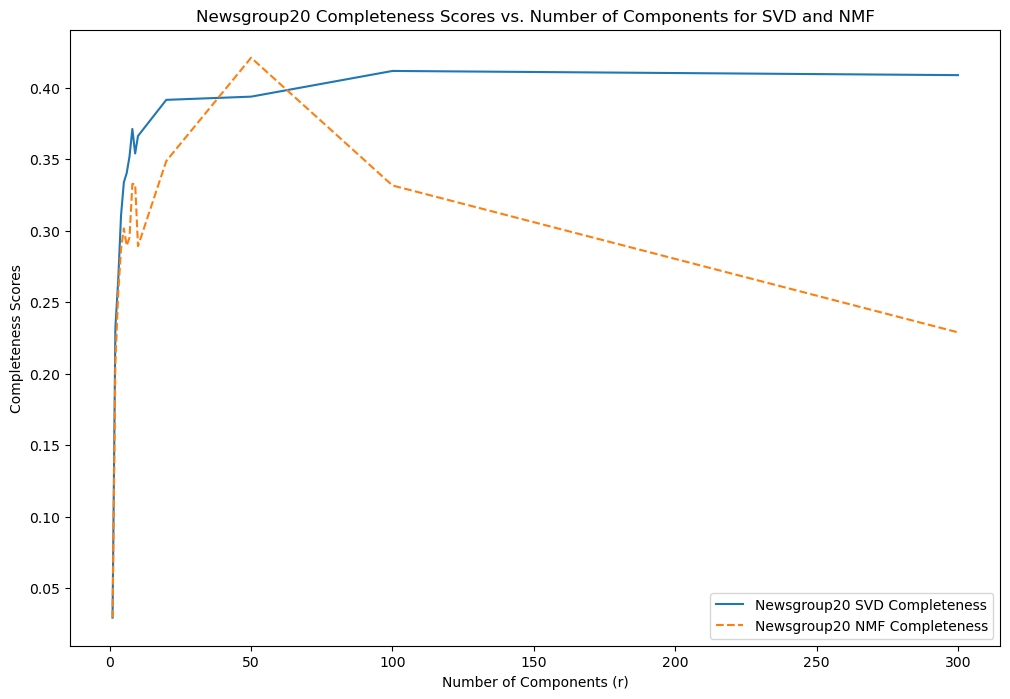

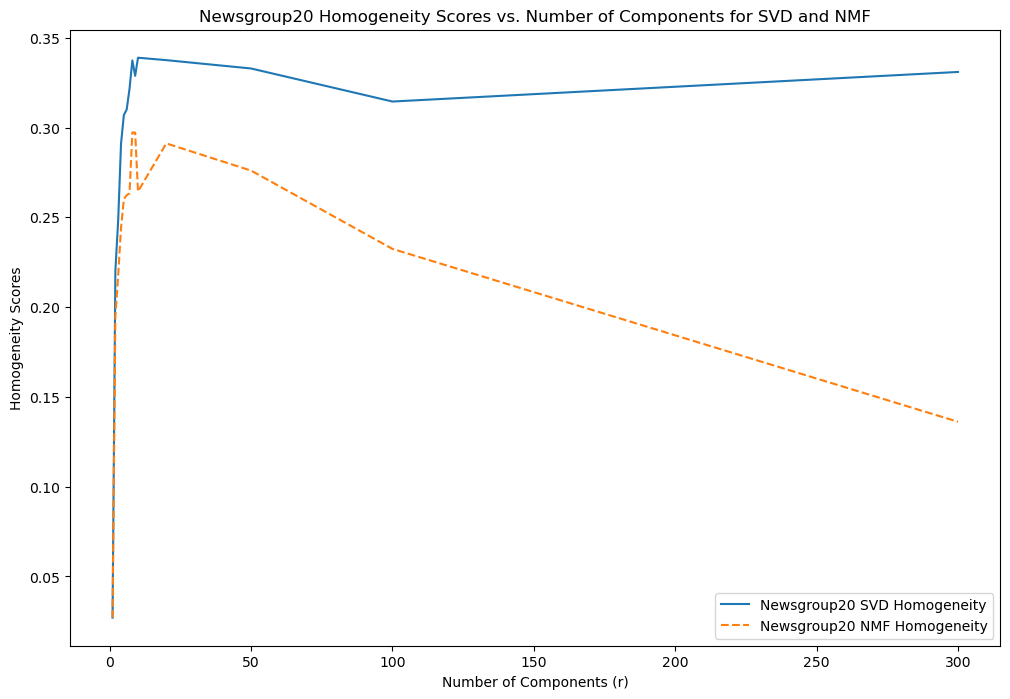

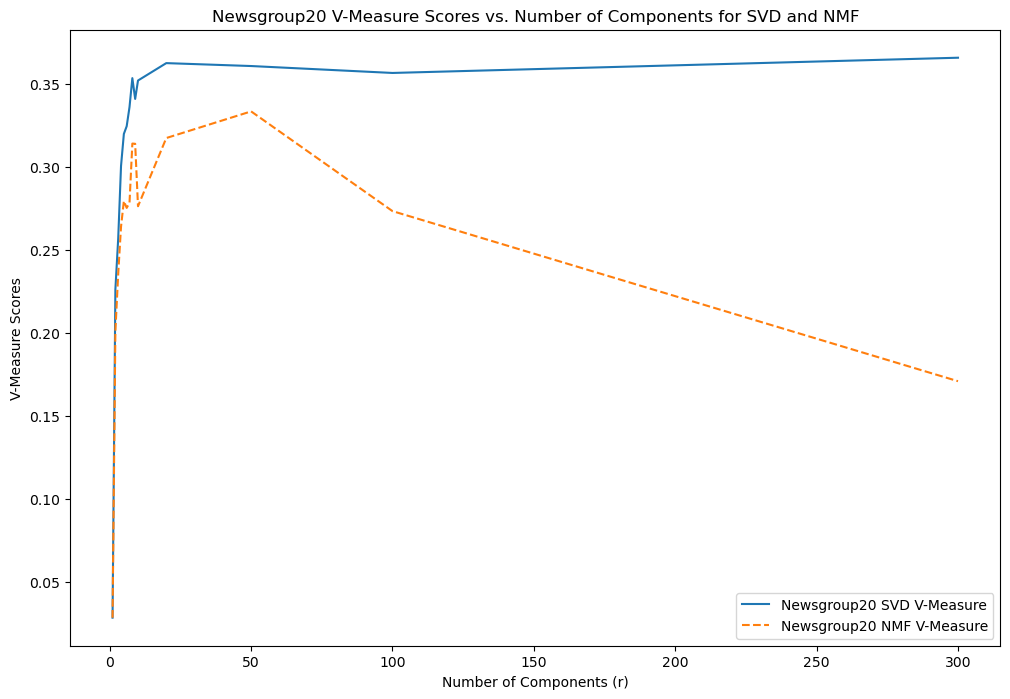

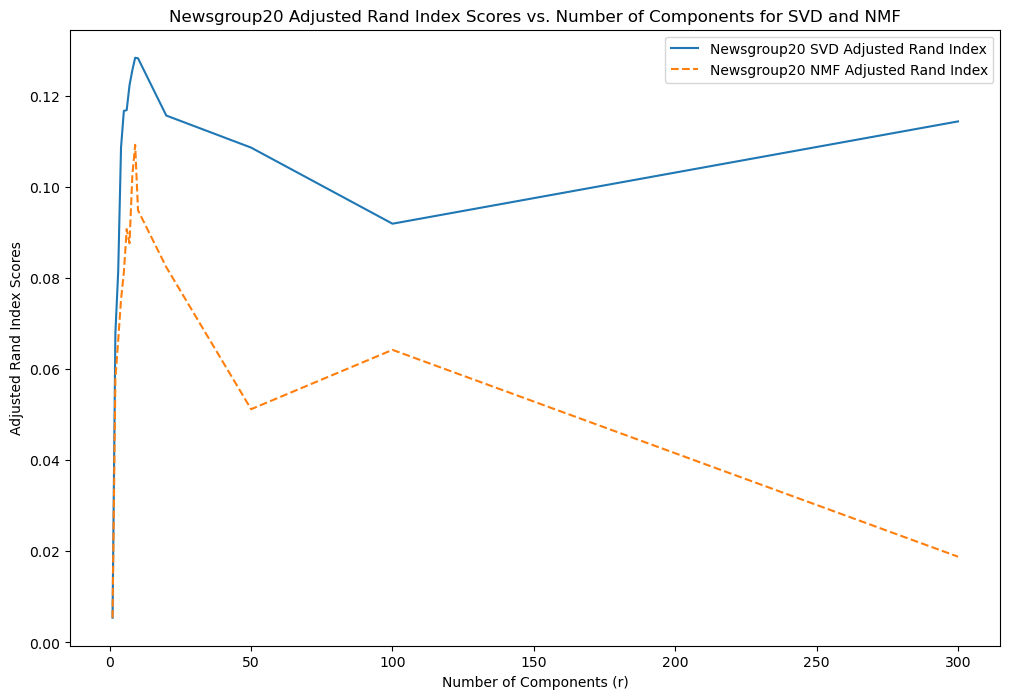

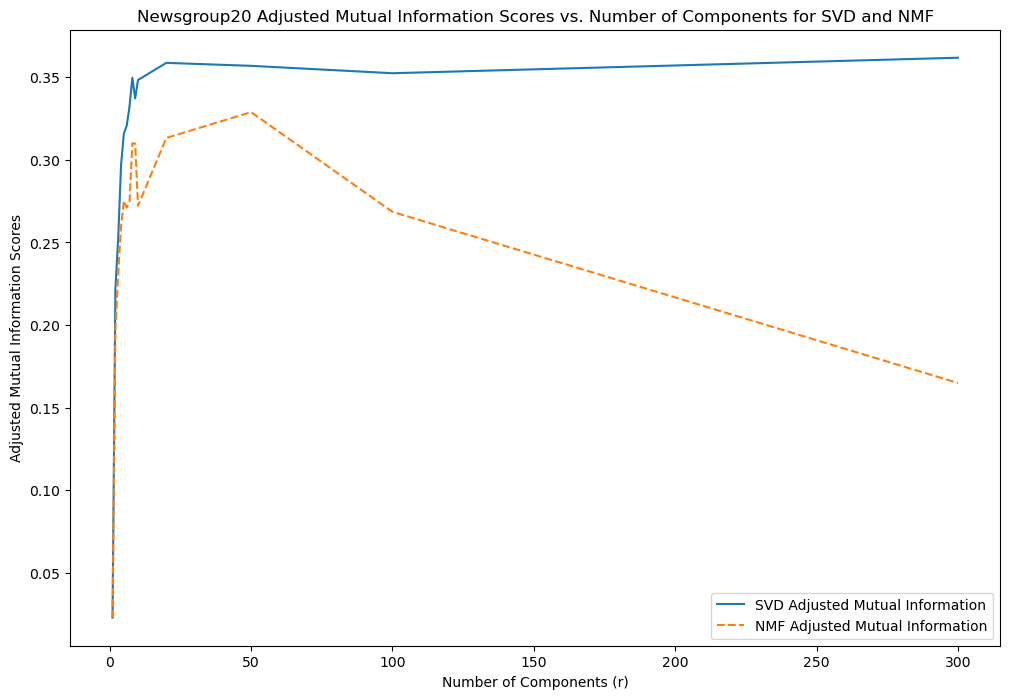

In [13]:
# Comparing SVD and NMF completeness scores:
plt.figure(figsize=(12, 8))
plt.plot(r_list, newsgroup20_svd_measure_scores.get('Completeness'), label=f'Newsgroup20 SVD Completeness')
plt.plot(r_list, newsgroup20_nmf_measure_scores.get('Completeness'), label=f'Newsgroup20 NMF Completeness', linestyle='dashed')
plt.xlabel('Number of Components (r)')
plt.ylabel('Completeness Scores')
plt.title('Newsgroup20 Completeness Scores vs. Number of Components for SVD and NMF')
plt.legend()

# Comparing SVD and NMF homogeneity scores:
plt.figure(figsize=(12, 8))
plt.plot(r_list, newsgroup20_svd_measure_scores.get('Homogeneity'), label=f'Newsgroup20 SVD Homogeneity')
plt.plot(r_list, newsgroup20_nmf_measure_scores.get('Homogeneity'), label=f'Newsgroup20 NMF Homogeneity', linestyle='dashed')
plt.xlabel('Number of Components (r)')
plt.ylabel('Homogeneity Scores')
plt.title('Newsgroup20 Homogeneity Scores vs. Number of Components for SVD and NMF')
plt.legend()

# Comparing SVD and NMF v-measure scores:
plt.figure(figsize=(12, 8))
plt.plot(r_list, newsgroup20_svd_measure_scores.get('V-Measure'), label=f'Newsgroup20 SVD V-Measure')
plt.plot(r_list, newsgroup20_nmf_measure_scores.get('V-Measure'), label=f'Newsgroup20 NMF V-Measure', linestyle='dashed')
plt.xlabel('Number of Components (r)')
plt.ylabel('V-Measure Scores')
plt.title('Newsgroup20 V-Measure Scores vs. Number of Components for SVD and NMF')
plt.legend()

# Comparing SVD and NMF adjusted rand index scores:
plt.figure(figsize=(12, 8))
plt.plot(r_list, newsgroup20_svd_measure_scores.get('ARI'), label=f'Newsgroup20 SVD Adjusted Rand Index')
plt.plot(r_list, newsgroup20_nmf_measure_scores.get('ARI'), label=f'Newsgroup20 NMF Adjusted Rand Index', linestyle='dashed')
plt.xlabel('Number of Components (r)')
plt.ylabel('Adjusted Rand Index Scores')
plt.title('Newsgroup20 Adjusted Rand Index Scores vs. Number of Components for SVD and NMF')
plt.legend()

# Comparing SVD and NMF adjusted mutual information scores:
plt.figure(figsize=(12, 8))
plt.plot(r_list, newsgroup20_svd_measure_scores.get('AMI'), label=f'SVD Adjusted Mutual Information')
plt.plot(r_list, newsgroup20_nmf_measure_scores.get('AMI'), label=f'NMF Adjusted Mutual Information', linestyle='dashed')
plt.xlabel('Number of Components (r)')
plt.ylabel('Adjusted Mutual Information Scores')
plt.title('Newsgroup20 Adjusted Mutual Information Scores vs. Number of Components for SVD and NMF')
plt.legend()

In [14]:
# Finding the r with the best measured scores for svd

for k in newsgroup20_svd_measure_scores:
    print(f'Newsgroup20 SVD {k} scores : {newsgroup20_svd_measure_scores[k]}')

print()

# Finding the r with the best completeness score
newsgroup20_best_svd_completeness_score = max(newsgroup20_svd_measure_scores['Completeness'])
try:
    newsgroup20_best_svd_completeness_score_index = newsgroup20_svd_measure_scores['Completeness'].index(newsgroup20_best_svd_completeness_score)
except ValueError:
    print("Element not found in the list.")
newsgroup20_best_svd_completeness_score_r = r_list[newsgroup20_best_svd_completeness_score_index]

print("Newsgroup20 Best svd completeness score: ", newsgroup20_best_svd_completeness_score)
print("Newsgroup20 Best svd completeness score 'r': ", newsgroup20_best_svd_completeness_score_r)
print()

# Finding the r with the best homogeneity score
newsgroup20_best_svd_homogeneity_score = max(newsgroup20_svd_measure_scores['Homogeneity'])
try:
    newsgroup20_best_svd_homogeneity_score_index = newsgroup20_svd_measure_scores['Homogeneity'].index(newsgroup20_best_svd_homogeneity_score)
except ValueError:
    print("Element not found in the list.")
newsgroup20_best_svd_homogeneity_score_r = r_list[newsgroup20_best_svd_homogeneity_score_index]

print("Newsgroup20 Best svd homogeneity score: ", newsgroup20_best_svd_homogeneity_score)
print("Newsgroup20 Best svd homogeneity score 'r': ", newsgroup20_best_svd_homogeneity_score_r)
print()

# Finding the r with the best V-Measure score
newsgroup20_best_svd_v_measure_score = max(newsgroup20_svd_measure_scores['V-Measure'])
try:
    newsgroup20_best_svd_v_measure_score_index = newsgroup20_svd_measure_scores['V-Measure'].index(newsgroup20_best_svd_v_measure_score)
except ValueError:
    print("Element not found in the list.")
newsgroup20_best_svd_v_measure_score_r = r_list[newsgroup20_best_svd_v_measure_score_index]

print("Newsgroup20 Best svd V-Measure score: ", newsgroup20_best_svd_v_measure_score)
print("Newsgroup20 Best svd V-Measure score 'r': ", newsgroup20_best_svd_v_measure_score_r)
print()

# Finding the r with the best Adjusted Rand Index score
newsgroup20_best_svd_ari_score = max(newsgroup20_svd_measure_scores['ARI'])
try:
    newsgroup20_best_svd_ari_score_index = newsgroup20_svd_measure_scores['ARI'].index(newsgroup20_best_svd_ari_score)
except ValueError:
    print("Element not found in the list.")
newsgroup20_best_svd_ari_score_r = r_list[newsgroup20_best_svd_ari_score_index]

print("Newsgroup20 Best svd Adjusted Rand Index score: ", newsgroup20_best_svd_ari_score)
print("Newsgroup20 Best svd Adjusted Rand Index score 'r': ", newsgroup20_best_svd_ari_score_r)
print()

# Finding the r with the best Adjusted Mutual Information score
newsgroup20_best_svd_ami_score = max(newsgroup20_svd_measure_scores['AMI'])
try:
    newsgroup20_best_svd_ami_score_index = newsgroup20_svd_measure_scores['AMI'].index(newsgroup20_best_svd_ami_score)
except ValueError:
    print("Element not found in the list.")
newsgroup20_best_svd_ami_score_r = r_list[newsgroup20_best_svd_ami_score_index]

print("Newsgroup20 Best svd Adjusted Mutual Information score: ", newsgroup20_best_svd_ami_score)
print("Newsgroup20 Best svd Adjusted Mutual Information score 'r': ", newsgroup20_best_svd_ami_score_r)

Newsgroup20 SVD ARI scores : [0.005433422149837826, 0.06785050938830677, 0.0814407448594994, 0.10866349285060824, 0.11666438773266008, 0.11682458058285199, 0.12228749900455851, 0.1255865398307345, 0.12832887045190933, 0.12821254760153286, 0.11564055013672209, 0.10860240799686473, 0.09190136595495009, 0.11435006625961701]
Newsgroup20 SVD AMI scores : [0.022697825648521408, 0.22170510593637796, 0.2525708493207064, 0.296593222299408, 0.3159641368053532, 0.3206087252355211, 0.3322789554021733, 0.34976984729138233, 0.3372140114959246, 0.34837510928776083, 0.3587736243093985, 0.3569708515591458, 0.35250042046032204, 0.36188797365088676]
Newsgroup20 SVD Homogeneity scores : [0.027075035561315852, 0.220258071535113, 0.2486712224942154, 0.29104531443912085, 0.3069338742959679, 0.31004852587910064, 0.32152658030354825, 0.33735877478845, 0.3287707989366111, 0.3388602669151277, 0.3375148402474223, 0.3328620393429381, 0.3144667734454316, 0.33093212252249127]
Newsgroup20 SVD Completeness scores : [0

In [15]:
# Finding the r with the best measured scores for nmf

for k in newsgroup20_nmf_measure_scores:
    print(f'Newsgroup20 NMF {k} scores : {newsgroup20_nmf_measure_scores[k]}')

print()

# Finding the r with the best completeness score
newsgroup20_best_nmf_completeness_score = max(newsgroup20_nmf_measure_scores['Completeness'])
try:
    newsgroup20_best_nmf_completeness_score_index = newsgroup20_nmf_measure_scores['Completeness'].index(newsgroup20_best_nmf_completeness_score)
except ValueError:
    print("Element not found in the list.")
newsgroup20_best_nmf_completeness_score_r = r_list[newsgroup20_best_nmf_completeness_score_index]

print("Newsgroup20 Best nmf completeness score: ", newsgroup20_best_nmf_completeness_score)
print("Newsgroup20 Best nmf completeness score 'r': ", newsgroup20_best_nmf_completeness_score_r)
print()

# Finding the r with the best homogeneity score
newsgroup20_best_nmf_homogeneity_score = max(newsgroup20_nmf_measure_scores['Homogeneity'])
try:
    newsgroup20_best_nmf_homogeneity_score_index = newsgroup20_nmf_measure_scores['Homogeneity'].index(newsgroup20_best_nmf_homogeneity_score)
except ValueError:
    print("Element not found in the list.")
newsgroup20_best_nmf_homogeneity_score_r = r_list[newsgroup20_best_nmf_homogeneity_score_index]

print("Newsgroup20 Best nmf homogeneity score: ", newsgroup20_best_nmf_homogeneity_score)
print("Newsgroup20 Best nmf homogeneity score 'r': ", newsgroup20_best_nmf_homogeneity_score_r)
print()

# Finding the r with the best V-Measure score
newsgroup20_best_nmf_v_measure_score = max(newsgroup20_nmf_measure_scores['V-Measure'])
try:
    newsgroup20_best_nmf_v_measure_score_index = newsgroup20_nmf_measure_scores['V-Measure'].index(newsgroup20_best_nmf_v_measure_score)
except ValueError:
    print("Element not found in the list.")
newsgroup20_best_nmf_v_measure_score_r = r_list[newsgroup20_best_nmf_v_measure_score_index]

print("Newsgroup20 Best nmf V-Measure score: ", newsgroup20_best_nmf_v_measure_score)
print("Newsgroup20 Best nmf V-Measure score 'r': ", newsgroup20_best_nmf_v_measure_score_r)
print()

# Finding the r with the best Adjusted Rand Index score
newsgroup20_best_nmf_ari_score = max(newsgroup20_nmf_measure_scores['ARI'])
try:
    newsgroup20_best_nmf_ari_score_index = newsgroup20_nmf_measure_scores['ARI'].index(newsgroup20_best_nmf_ari_score)
except ValueError:
    print("Element not found in the list.")
newsgroup20_best_nmf_ari_score_r = r_list[newsgroup20_best_nmf_ari_score_index]

print("Newsgroup20 Best nmf Adjusted Rand Index score: ", newsgroup20_best_nmf_ari_score)
print("Newsgroup20 Best nmf Adjusted Rand Index score 'r': ", newsgroup20_best_nmf_ari_score_r)
print()

# Finding the r with the best Adjusted Mutual Information score
newsgroup20_best_nmf_ami_score = max(newsgroup20_nmf_measure_scores['AMI'])
try:
    newsgroup20_best_nmf_ami_score_index = newsgroup20_nmf_measure_scores['AMI'].index(newsgroup20_best_nmf_ami_score)
except ValueError:
    print("Element not found in the list.")
newsgroup20_best_nmf_ami_score_r = r_list[newsgroup20_best_nmf_ami_score_index]

print("Newsgroup20 Best nmf Adjusted Mutual Information score: ", newsgroup20_best_nmf_ami_score)
print("Newsgroup20 Best nmf Adjusted Mutual Information score 'r': ", newsgroup20_best_nmf_ami_score_r)

Newsgroup20 NMF ARI scores : [0.00542988257375794, 0.057814430777091017, 0.0663095757509112, 0.07526042071710001, 0.08117779738625686, 0.09070899232501262, 0.08761241503153272, 0.10251610568470491, 0.10921076227293879, 0.09485378264741325, 0.08237798625939444, 0.05119369194370699, 0.06421823045093443, 0.01883050248491745]
Newsgroup20 NMF AMI scores : [0.022667700535662173, 0.1964664289797043, 0.2309370383888438, 0.2595754917115553, 0.27511044158705095, 0.27106495446615675, 0.27423734560442886, 0.3100495970264564, 0.30992794921073064, 0.27211346205433506, 0.3132581920808366, 0.3289290465346211, 0.26852084363633133, 0.16485846139944374]
Newsgroup20 NMF Homogeneity scores : [0.027046445140724493, 0.19491162046187993, 0.2177657210821709, 0.24415567686634884, 0.26019014959987163, 0.26228533985568314, 0.2634073970477231, 0.2972838182539705, 0.29715192400671575, 0.26439013298279745, 0.291152557507311, 0.2760010367197732, 0.2324042300532928, 0.13615740607937804]
Newsgroup20 NMF Completeness sc

In [16]:
# Finding the average measured scores for each r in svd

average_measured_score_svd = {}
for i in range(len(r_list)):
    sum = 0
    for k, v in newsgroup20_svd_measure_scores.items():
        sum += v[i]
    average = sum/len(r_list)
    average_measured_score_svd[r_list[i]] = average

# finding the best 'r' based on the best average measured scores

print(average_measured_score_svd)
svd_max_average_measured_score_key = max(average_measured_score_svd, key=average_measured_score_svd.get)
svd_max_average_measured_score_value = average_measured_score_svd[svd_max_average_measured_score_key]
print("Best svd average mesured score for newsgroup20: ", svd_max_average_measured_score_value)
print("Best svd 'r' for newsgroup20: ", svd_max_average_measured_score_key)

{1: 0.008058213549340698, 2: 0.06913849282072516, 3: 0.07891696378306312, 4: 0.09339325590098944, 5: 0.0995192980034544, 6: 0.10087530798904784, 7: 0.10457862320288595, 8: 0.10981049504169269, 9: 0.10637597633260398, 10: 0.10955257207157196, 20: 0.1118539342710845, 50: 0.11092493490425027, 100: 0.10908476475313476, 300: 0.11298120140521573}
Best svd average mesured score for newsgroup20:  0.11298120140521573
Best svd 'r' for newsgroup20:  300


In [17]:
# Finding the average measured scores for each r in svd

average_measured_score_nmf = {}
for i in range(len(r_list)):
    sum = 0
    for k, v in newsgroup20_nmf_measure_scores.items():
        sum += v[i]
    average = sum/len(r_list)
    average_measured_score_nmf[r_list[i]] = average

# finding the best 'r' based on the best average measured scores

print(average_measured_score_nmf)
nmf_max_average_measured_score_key = max(average_measured_score_nmf, key=average_measured_score_nmf.get)
nmf_max_average_measured_score_value = average_measured_score_nmf[nmf_max_average_measured_score_key]
print("Best nmf average mesured score for newsgroup20: ", nmf_max_average_measured_score_value)
print("Best nmf 'r' for newsgroup20: ", nmf_max_average_measured_score_key)

{1: 0.00804936692551118, 2: 0.06125322035505417, 3: 0.07192103905374606, 4: 0.08073430194550917, 5: 0.08553485170879739, 6: 0.08491479235484321, 7: 0.08563601872448831, 8: 0.0969002903466343, 9: 0.09734163337762969, 10: 0.08548280748649617, 20: 0.09663290414150084, 50: 0.1007507605074368, 100: 0.08357683294413283, 300: 0.05139552576105908}
Best nmf average mesured score for newsgroup20:  0.1007507605074368
Best nmf 'r' for newsgroup20:  50


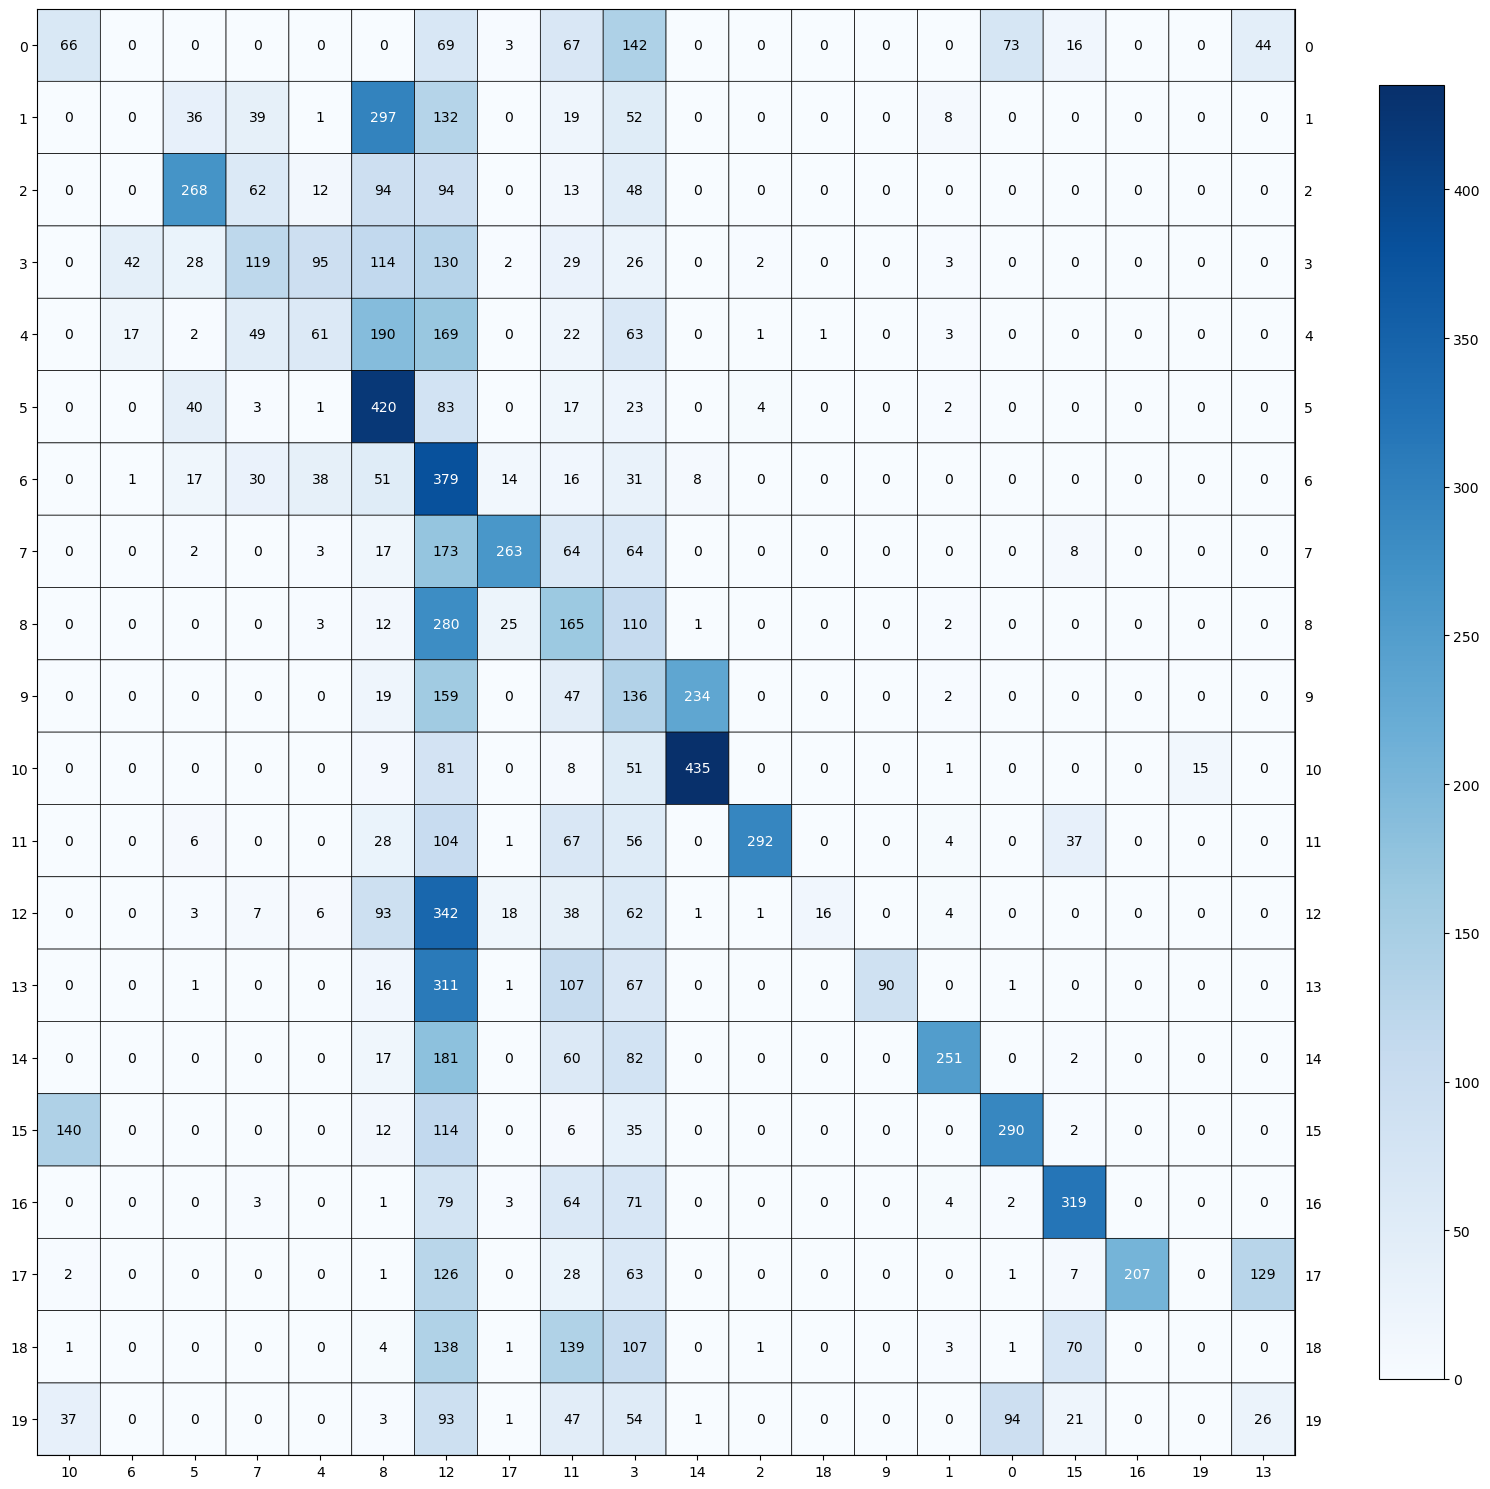

SVD of Newsgroup20 with the Optimal 'r' (r = 300) Contingency Table:
[[ 73   0   0 142   0   0   0   0   0   0  66  67  69  44   0  16   0   3
    0   0]
 [  0   8   0  52   1  36   0  39 297   0   0  19 132   0   0   0   0   0
    0   0]
 [  0   0   0  48  12 268   0  62  94   0   0  13  94   0   0   0   0   0
    0   0]
 [  0   3   2  26  95  28  42 119 114   0   0  29 130   0   0   0   0   2
    0   0]
 [  0   3   1  63  61   2  17  49 190   0   0  22 169   0   0   0   0   0
    1   0]
 [  0   2   4  23   1  40   0   3 420   0   0  17  83   0   0   0   0   0
    0   0]
 [  0   0   0  31  38  17   1  30  51   0   0  16 379   0   8   0   0  14
    0   0]
 [  0   0   0  64   3   2   0   0  17   0   0  64 173   0   0   8   0 263
    0   0]
 [  0   2   0 110   3   0   0   0  12   0   0 165 280   0   1   0   0  25
    0   0]
 [  0   2   0 136   0   0   0   0  19   0   0  47 159   0 234   0   0   0
    0   0]
 [  0   1   0  51   0   0   0   0   9   0   0   8  81   0 435   0   0   0
    0  

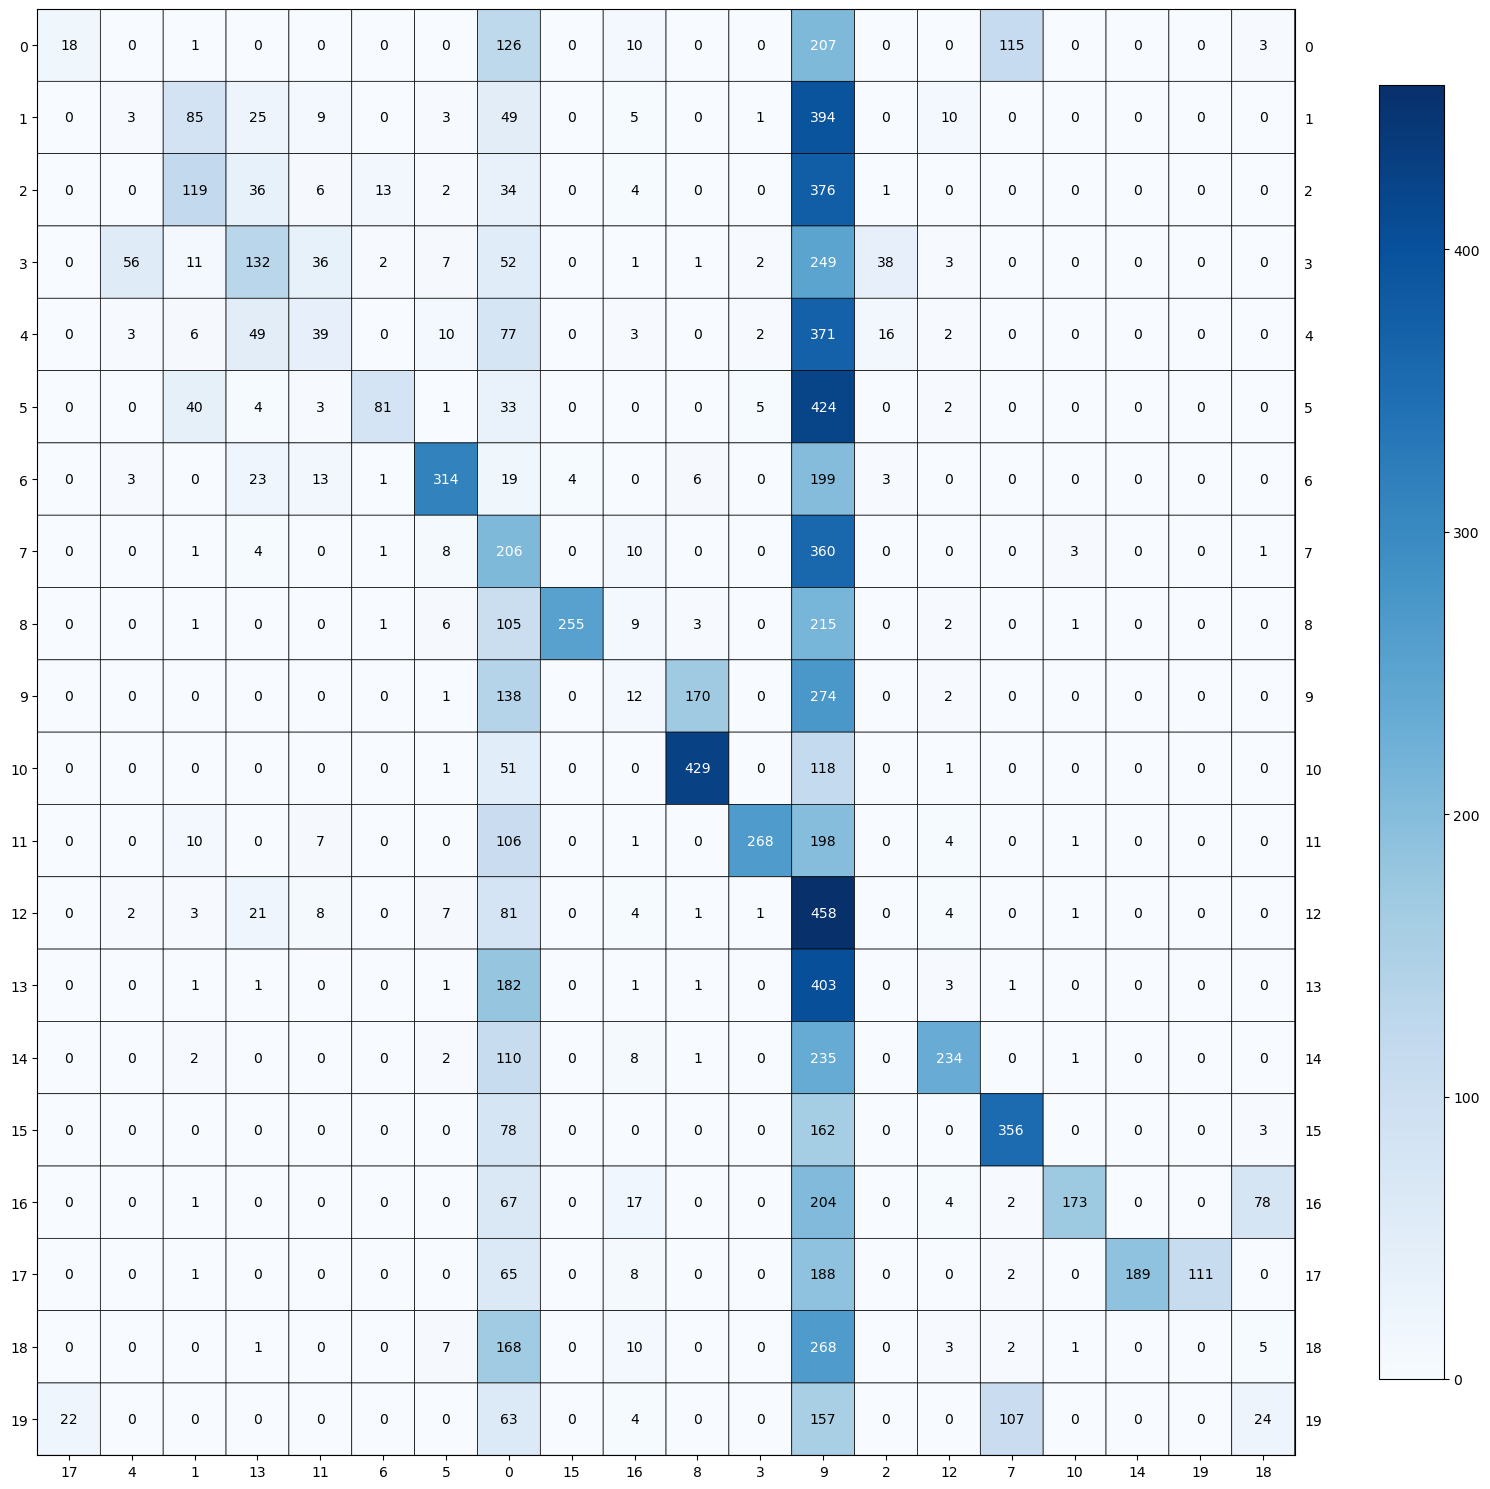

NMF of Newsgroup20 with the Optimal 'r' (r = 50) Contingency Table:
[[126   1   0   0   0   0   0 115   0 207   0   0   0   0   0   0  10  18
    3   0]
 [ 49  85   0   1   3   3   0   0   0 394   0   9  10  25   0   0   5   0
    0   0]
 [ 34 119   1   0   0   2  13   0   0 376   0   6   0  36   0   0   4   0
    0   0]
 [ 52  11  38   2  56   7   2   0   1 249   0  36   3 132   0   0   1   0
    0   0]
 [ 77   6  16   2   3  10   0   0   0 371   0  39   2  49   0   0   3   0
    0   0]
 [ 33  40   0   5   0   1  81   0   0 424   0   3   2   4   0   0   0   0
    0   0]
 [ 19   0   3   0   3 314   1   0   6 199   0  13   0  23   0   4   0   0
    0   0]
 [206   1   0   0   0   8   1   0   0 360   3   0   0   4   0   0  10   0
    1   0]
 [105   1   0   0   0   6   1   0   3 215   1   0   2   0   0 255   9   0
    0   0]
 [138   0   0   0   0   1   0   0 170 274   0   0   2   0   0   0  12   0
    0   0]
 [ 51   0   0   0   0   1   0   0 429 118   0   0   1   0   0   0   0   0
    0   

In [18]:
import numpy as np
from plotmat import plot_mat # using the provided plotmat.py
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix

newsgroup20_best_svd_r = 300
newsgroup20_best_nmf_r = 50

# SVD
newsgroup20_svd_with_best_r = TruncatedSVD(n_components=newsgroup20_best_svd_r, random_state=0)
newsgroup20_svd_with_best_r_transformed = newsgroup20_svd.fit_transform(newsgroup20_train_tfidf)
newsgroup20_svd_with_best_r_kmeans = KMeans(n_clusters=20, random_state=0, max_iter=1000, n_init=30)
newsgroup20_svd_with_best_r_kmeans.fit(newsgroup20_svd_with_best_r_transformed)
newsgroup20_svd_with_best_r_labels = newsgroup20_svd_with_best_r_kmeans.labels_

newsgroup20_svd_with_best_r_cm = confusion_matrix(newsgroup20_ground_truth_labels, newsgroup20_svd_with_best_r_labels)

rows, cols = linear_sum_assignment(newsgroup20_svd_with_best_r_cm, maximize=True)
plot_mat(newsgroup20_svd_with_best_r_cm[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, size=(15,15))

# Display the contingency table
print(f"SVD of Newsgroup20 with the Optimal 'r' (r = {newsgroup20_best_svd_r}) Contingency Table:")
print(newsgroup20_svd_with_best_r_cm)
print()

# rows, cols = linear_sum_assignment(contingency_matrix, maximize=True)
# plot_mat(contingency_matrix[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, size=(15,15))

try:
    newsgroup20_best_svd_r_index = r_list.index(newsgroup20_best_svd_r)
except ValueError:
    print("Element not found in the list.")

# Compute clustering measures
newsgroup20_svd_with_best_r_homogeneity = newsgroup20_svd_measure_scores['Homogeneity'][newsgroup20_best_svd_r_index]
newsgroup20_svd_with_best_r_completeness = newsgroup20_svd_measure_scores['Completeness'][newsgroup20_best_svd_r_index]
newsgroup20_svd_with_best_r_v_measure = newsgroup20_svd_measure_scores['V-Measure'][newsgroup20_best_svd_r_index]
newsgroup20_svd_with_best_r_adjusted_rand_index = newsgroup20_svd_measure_scores['ARI'][newsgroup20_best_svd_r_index]
newsgroup20_svd_with_best_r_adjusted_mutual_info = newsgroup20_svd_measure_scores['AMI'][newsgroup20_best_svd_r_index]

# Report clustering measures
print(f"SVD of Newsgroup20 with the Optimal 'r' (r = {newsgroup20_best_svd_r}) Clustering Measures:")
print(f"Homogeneity: {newsgroup20_svd_with_best_r_homogeneity}")
print(f"Completeness: {newsgroup20_svd_with_best_r_completeness}")
print(f"V-measure: {newsgroup20_svd_with_best_r_v_measure}")
print(f"Adjusted Rand Index: {newsgroup20_svd_with_best_r_adjusted_rand_index}")
print(f"Adjusted Mutual Information Score: {newsgroup20_svd_with_best_r_adjusted_mutual_info}")
print()

# SVD of Newsgroup20 with the Optimal 'r' Clustering Measures:
# Homogeneity: 0.3309
# Completeness: 0.4088
# V-measure: 0.3658
# Adjusted Rand Index: 0.1144
# Adjusted Mutual Information Score: 0.3619

# NMF
newsgroup20_nmf_with_best_r = NMF(n_components=newsgroup20_best_nmf_r, max_iter=1000, init='random', random_state=0)
newsgroup20_nmf_with_best_r_transformed = newsgroup20_nmf_with_best_r.fit_transform(newsgroup20_train_tfidf)
newsgroup20_nmf_with_best_r_kmeans = KMeans(n_clusters=20, random_state=0, max_iter=1000, n_init=30)
newsgroup20_nmf_with_best_r_kmeans.fit(newsgroup20_nmf_with_best_r_transformed)
newsgroup20_nmf_with_best_r_labels = newsgroup20_nmf_with_best_r_kmeans.labels_

newsgroup20_nmf_with_best_r_cm = confusion_matrix(newsgroup20_ground_truth_labels, newsgroup20_nmf_with_best_r_labels)

rows, cols = linear_sum_assignment(newsgroup20_nmf_with_best_r_cm, maximize=True)
plot_mat(newsgroup20_nmf_with_best_r_cm[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, size=(15,15))

# Display the contingency table
print(f"NMF of Newsgroup20 with the Optimal 'r' (r = {newsgroup20_best_nmf_r}) Contingency Table:")
print(newsgroup20_nmf_with_best_r_cm)
print()

# rows, cols = linear_sum_assignment(contingency_matrix, maximize=True)
# plot_mat(contingency_matrix[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, size=(15,15))

try:
    newsgroup20_best_nmf_r_index = r_list.index(newsgroup20_best_nmf_r)
except ValueError:
    print("Element not found in the list.")

# Compute clustering measures
newsgroup20_nmf_with_best_r_homogeneity = newsgroup20_nmf_measure_scores['Homogeneity'][newsgroup20_best_nmf_r_index]
newsgroup20_nmf_with_best_r_completeness = newsgroup20_nmf_measure_scores['Completeness'][newsgroup20_best_nmf_r_index]
newsgroup20_nmf_with_best_r_v_measure = newsgroup20_nmf_measure_scores['V-Measure'][newsgroup20_best_nmf_r_index]
newsgroup20_nmf_with_best_r_adjusted_rand_index = newsgroup20_nmf_measure_scores['ARI'][newsgroup20_best_nmf_r_index]
newsgroup20_nmf_with_best_r_adjusted_mutual_info = newsgroup20_nmf_measure_scores['AMI'][newsgroup20_best_nmf_r_index]

# Report clustering measures
print(f"NMF of Newsgroup20 with the Optimal 'r' (r = {newsgroup20_best_nmf_r}) Clustering Measures:")
print(f"Homogeneity: {newsgroup20_nmf_with_best_r_homogeneity}")
print(f"Completeness: {newsgroup20_nmf_with_best_r_completeness}")
print(f"V-measure: {newsgroup20_nmf_with_best_r_v_measure}")
print(f"Adjusted Rand Index: {newsgroup20_nmf_with_best_r_adjusted_rand_index}")
print(f"Adjusted Mutual Information Score: {newsgroup20_nmf_with_best_r_adjusted_mutual_info}")

# NMF of Newsgroup20 with the Optimal 'r' Clustering Measures:
# Homogeneity: 0.2760
# Completeness: 0.4210
# V-measure: 0.3334
# Adjusted Rand Index: 0.0512
# Adjusted Mutual Information Score: 0.3289


In [24]:
import umap
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

umap_n_components = [5, 20, 200]
umap_cosine = {'CM': [], 'Completeness': [], 'Homogeneity': [], 'V-Measure': [], 'ARI': [], 'AMI': []}
umap_euclidean = {'CM': [], 'Completeness': [], 'Homogeneity': [], 'V-Measure': [], 'ARI': [], 'AMI': []}

for comp in umap_n_components:
    umap_cosine_model = umap.UMAP(n_components=comp, metric='cosine')
    umap_cosine_result = umap_cosine_model.fit_transform(newsgroup20_train_tfidf)
    
    umap_cosine_kmeans = KMeans(n_clusters=20, random_state=0, max_iter=1000, n_init=30)
    umap_cosine_kmeans_labels = umap_cosine_kmeans.fit_predict(umap_cosine_result)

    # Evaluate clustering performance using different metrics
    umap_cosine['CM'].append(confusion_matrix(newsgroup20_ground_truth_labels, umap_cosine_kmeans_labels))
    umap_cosine['ARI'].append(adjusted_rand_score(newsgroup20_ground_truth_labels, umap_cosine_kmeans_labels))
    umap_cosine['AMI'].append(adjusted_mutual_info_score(newsgroup20_ground_truth_labels, umap_cosine_kmeans_labels))
    umap_cosine['Homogeneity'].append(homogeneity_score(newsgroup20_ground_truth_labels, umap_cosine_kmeans_labels))
    umap_cosine['Completeness'].append(completeness_score(newsgroup20_ground_truth_labels, umap_cosine_kmeans_labels))
    umap_cosine['V-Measure'].append(v_measure_score(newsgroup20_ground_truth_labels, umap_cosine_kmeans_labels))
    
    umap_euclidean_model = umap.UMAP(n_components=comp, metric='euclidean')
    umap_euclidean_result = umap_euclidean_model.fit_transform(newsgroup20_train_tfidf)
    
    umap_euclidean_kmeans = KMeans(n_clusters=20, random_state=0, max_iter=1000, n_init=30) 
    umap_euclidean_kmeans_labels = umap_euclidean_kmeans.fit_predict(umap_euclidean_result)

    # Evaluate clustering performance using different metrics
    umap_euclidean['CM'].append(confusion_matrix(newsgroup20_ground_truth_labels, umap_euclidean_kmeans_labels))
    umap_euclidean['ARI'].append(adjusted_rand_score(newsgroup20_ground_truth_labels, umap_euclidean_kmeans_labels))
    umap_euclidean['AMI'].append(adjusted_mutual_info_score(newsgroup20_ground_truth_labels, umap_euclidean_kmeans_labels))
    umap_euclidean['Homogeneity'].append(homogeneity_score(newsgroup20_ground_truth_labels, umap_euclidean_kmeans_labels))
    umap_euclidean['Completeness'].append(completeness_score(newsgroup20_ground_truth_labels, umap_euclidean_kmeans_labels))
    umap_euclidean['V-Measure'].append(v_measure_score(newsgroup20_ground_truth_labels, umap_euclidean_kmeans_labels))


Cosine UMAP with n_component = 5 Clustering Measures:


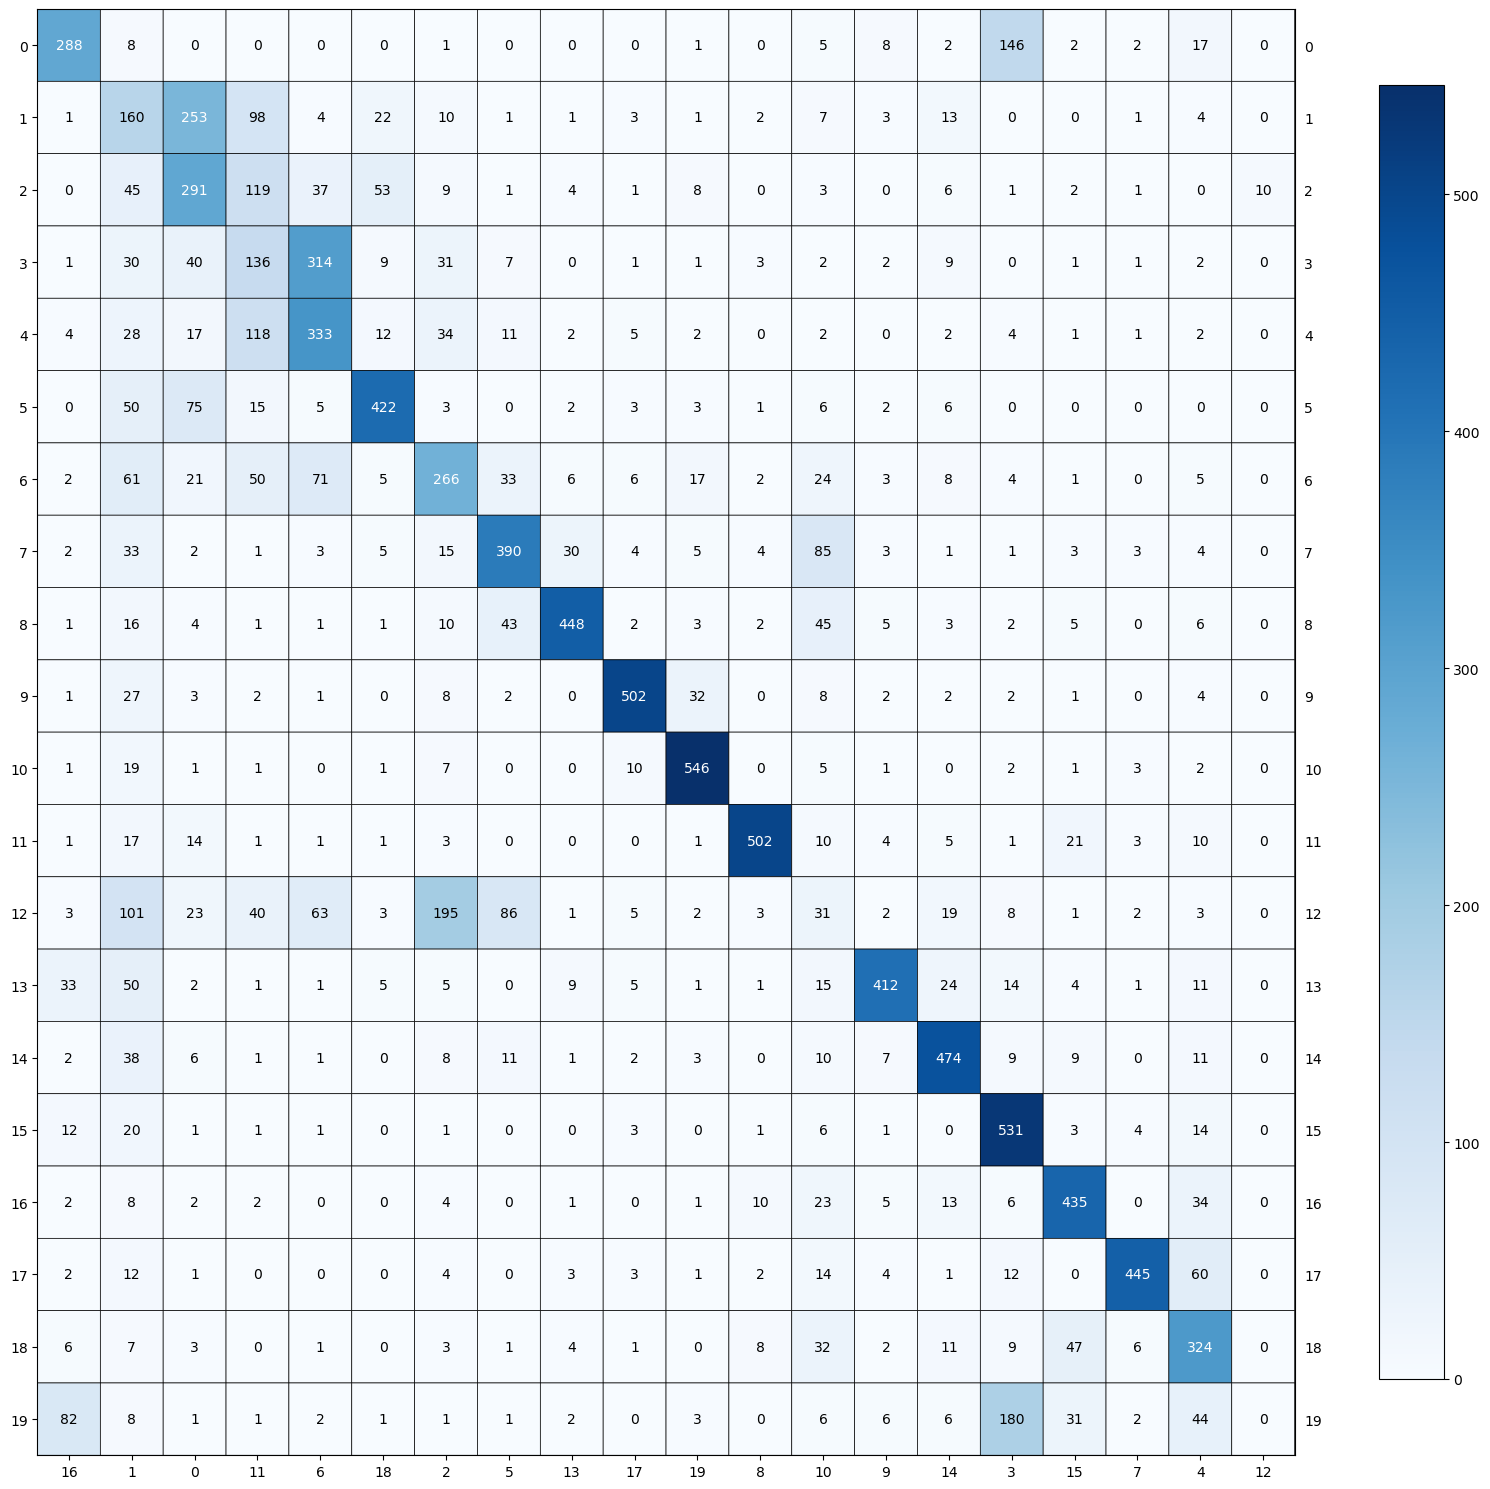

Contingency Matrix: 
 [[  0   8   1 146  17   0   0   2   0   8   5   0   0   0   2   2 288   0
    0   1]
 [253 160  10   0   4   1   4   1   2   3   7  98   0   1  13   0   1   3
   22   1]
 [291  45   9   1   0   1  37   1   0   0   3 119  10   4   6   2   0   1
   53   8]
 [ 40  30  31   0   2   7 314   1   3   2   2 136   0   0   9   1   1   1
    9   1]
 [ 17  28  34   4   2  11 333   1   0   0   2 118   0   2   2   1   4   5
   12   2]
 [ 75  50   3   0   0   0   5   0   1   2   6  15   0   2   6   0   0   3
  422   3]
 [ 21  61 266   4   5  33  71   0   2   3  24  50   0   6   8   1   2   6
    5  17]
 [  2  33  15   1   4 390   3   3   4   3  85   1   0  30   1   3   2   4
    5   5]
 [  4  16  10   2   6  43   1   0   2   5  45   1   0 448   3   5   1   2
    1   3]
 [  3  27   8   2   4   2   1   0   0   2   8   2   0   0   2   1   1 502
    0  32]
 [  1  19   7   2   2   0   0   3   0   1   5   1   0   0   0   1   1  10
    1 546]
 [ 14  17   3   1  10   0   1   3 502   4  

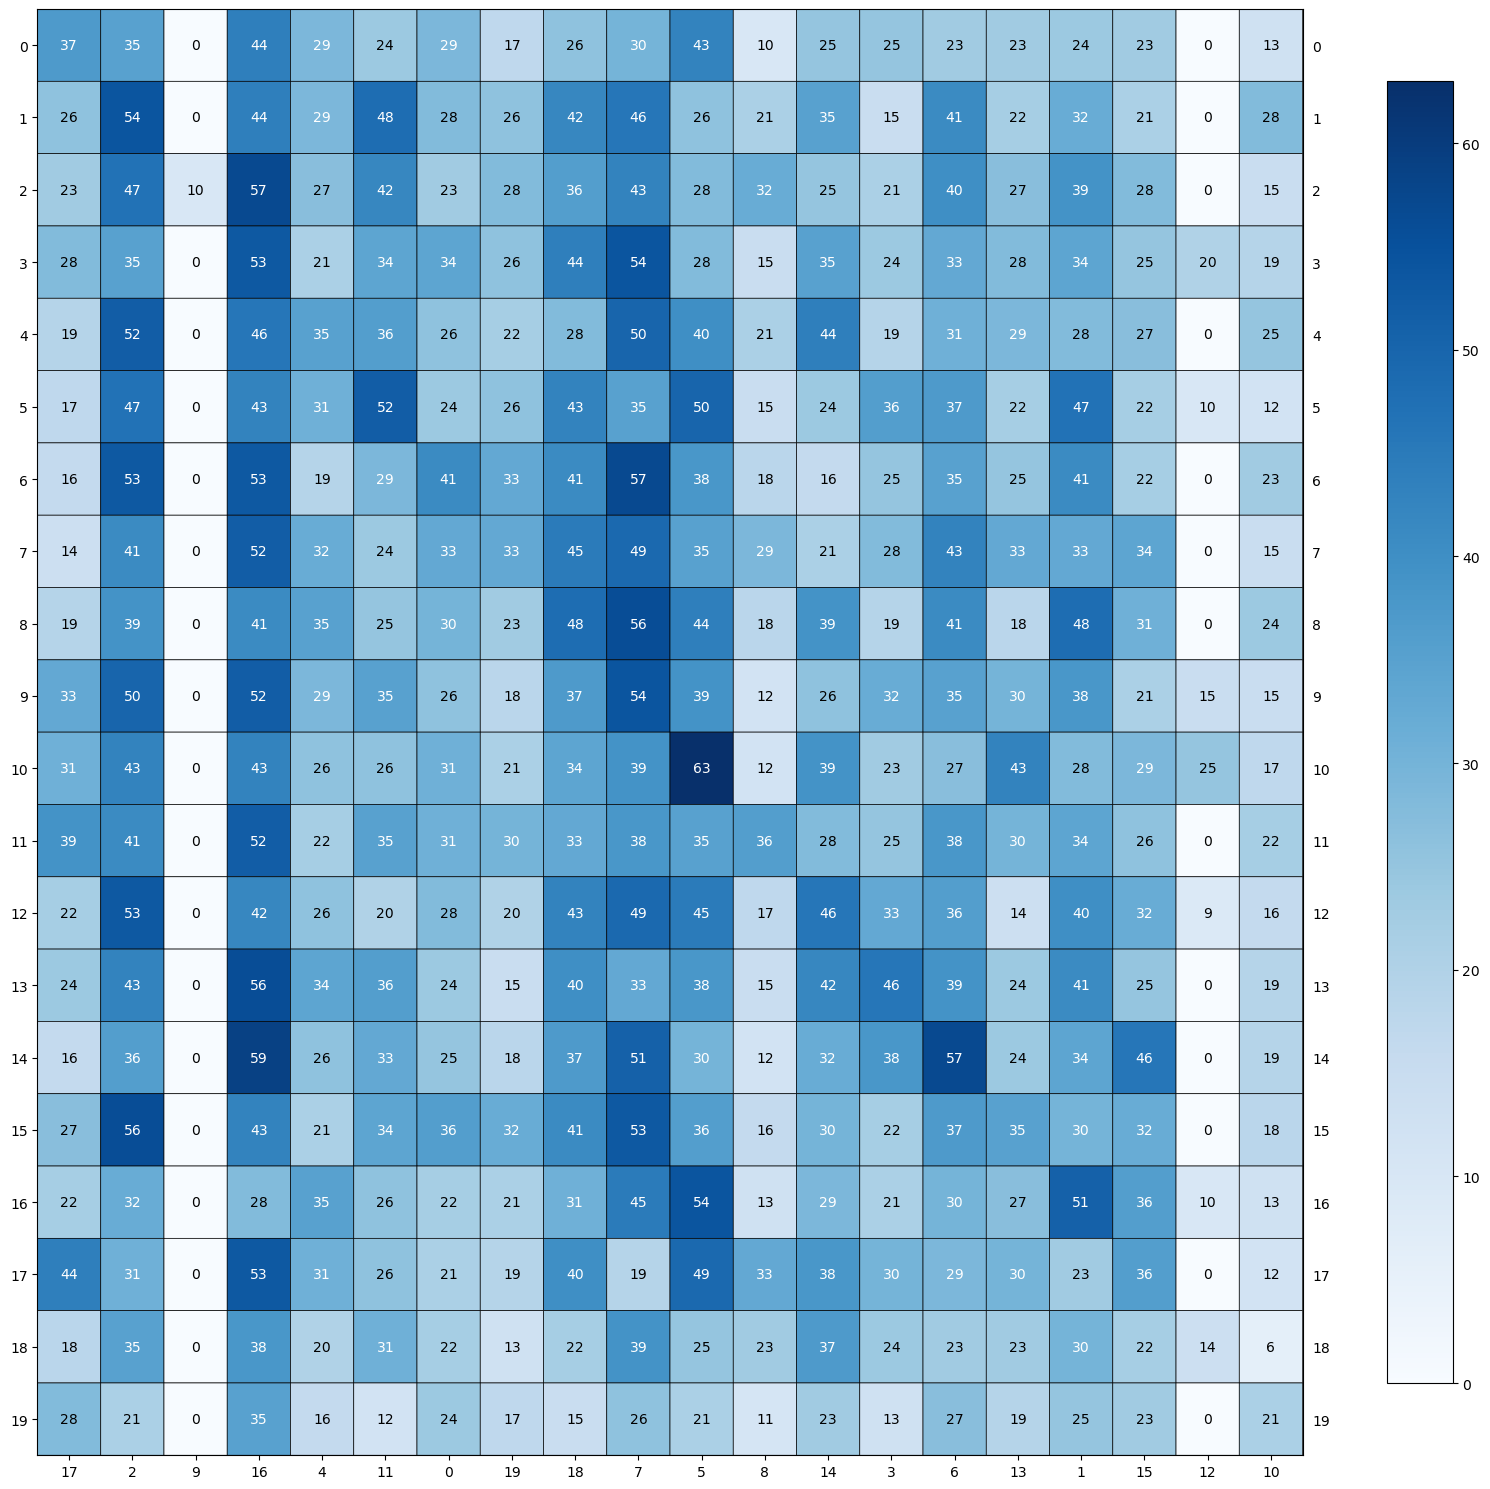

Contingency Matrix: 
 [[29 24 35 25 29 43 23 30 10  0 13 24  0 23 25 23 44 37 26 17]
 [28 32 54 15 29 26 41 46 21  0 28 48  0 22 35 21 44 26 42 26]
 [23 39 47 21 27 28 40 43 32 10 15 42  0 27 25 28 57 23 36 28]
 [34 34 35 24 21 28 33 54 15  0 19 34 20 28 35 25 53 28 44 26]
 [26 28 52 19 35 40 31 50 21  0 25 36  0 29 44 27 46 19 28 22]
 [24 47 47 36 31 50 37 35 15  0 12 52 10 22 24 22 43 17 43 26]
 [41 41 53 25 19 38 35 57 18  0 23 29  0 25 16 22 53 16 41 33]
 [33 33 41 28 32 35 43 49 29  0 15 24  0 33 21 34 52 14 45 33]
 [30 48 39 19 35 44 41 56 18  0 24 25  0 18 39 31 41 19 48 23]
 [26 38 50 32 29 39 35 54 12  0 15 35 15 30 26 21 52 33 37 18]
 [31 28 43 23 26 63 27 39 12  0 17 26 25 43 39 29 43 31 34 21]
 [31 34 41 25 22 35 38 38 36  0 22 35  0 30 28 26 52 39 33 30]
 [28 40 53 33 26 45 36 49 17  0 16 20  9 14 46 32 42 22 43 20]
 [24 41 43 46 34 38 39 33 15  0 19 36  0 24 42 25 56 24 40 15]
 [25 34 36 38 26 30 57 51 12  0 19 33  0 24 32 46 59 16 37 18]
 [36 30 56 22 21 36 37 53 16  0 1

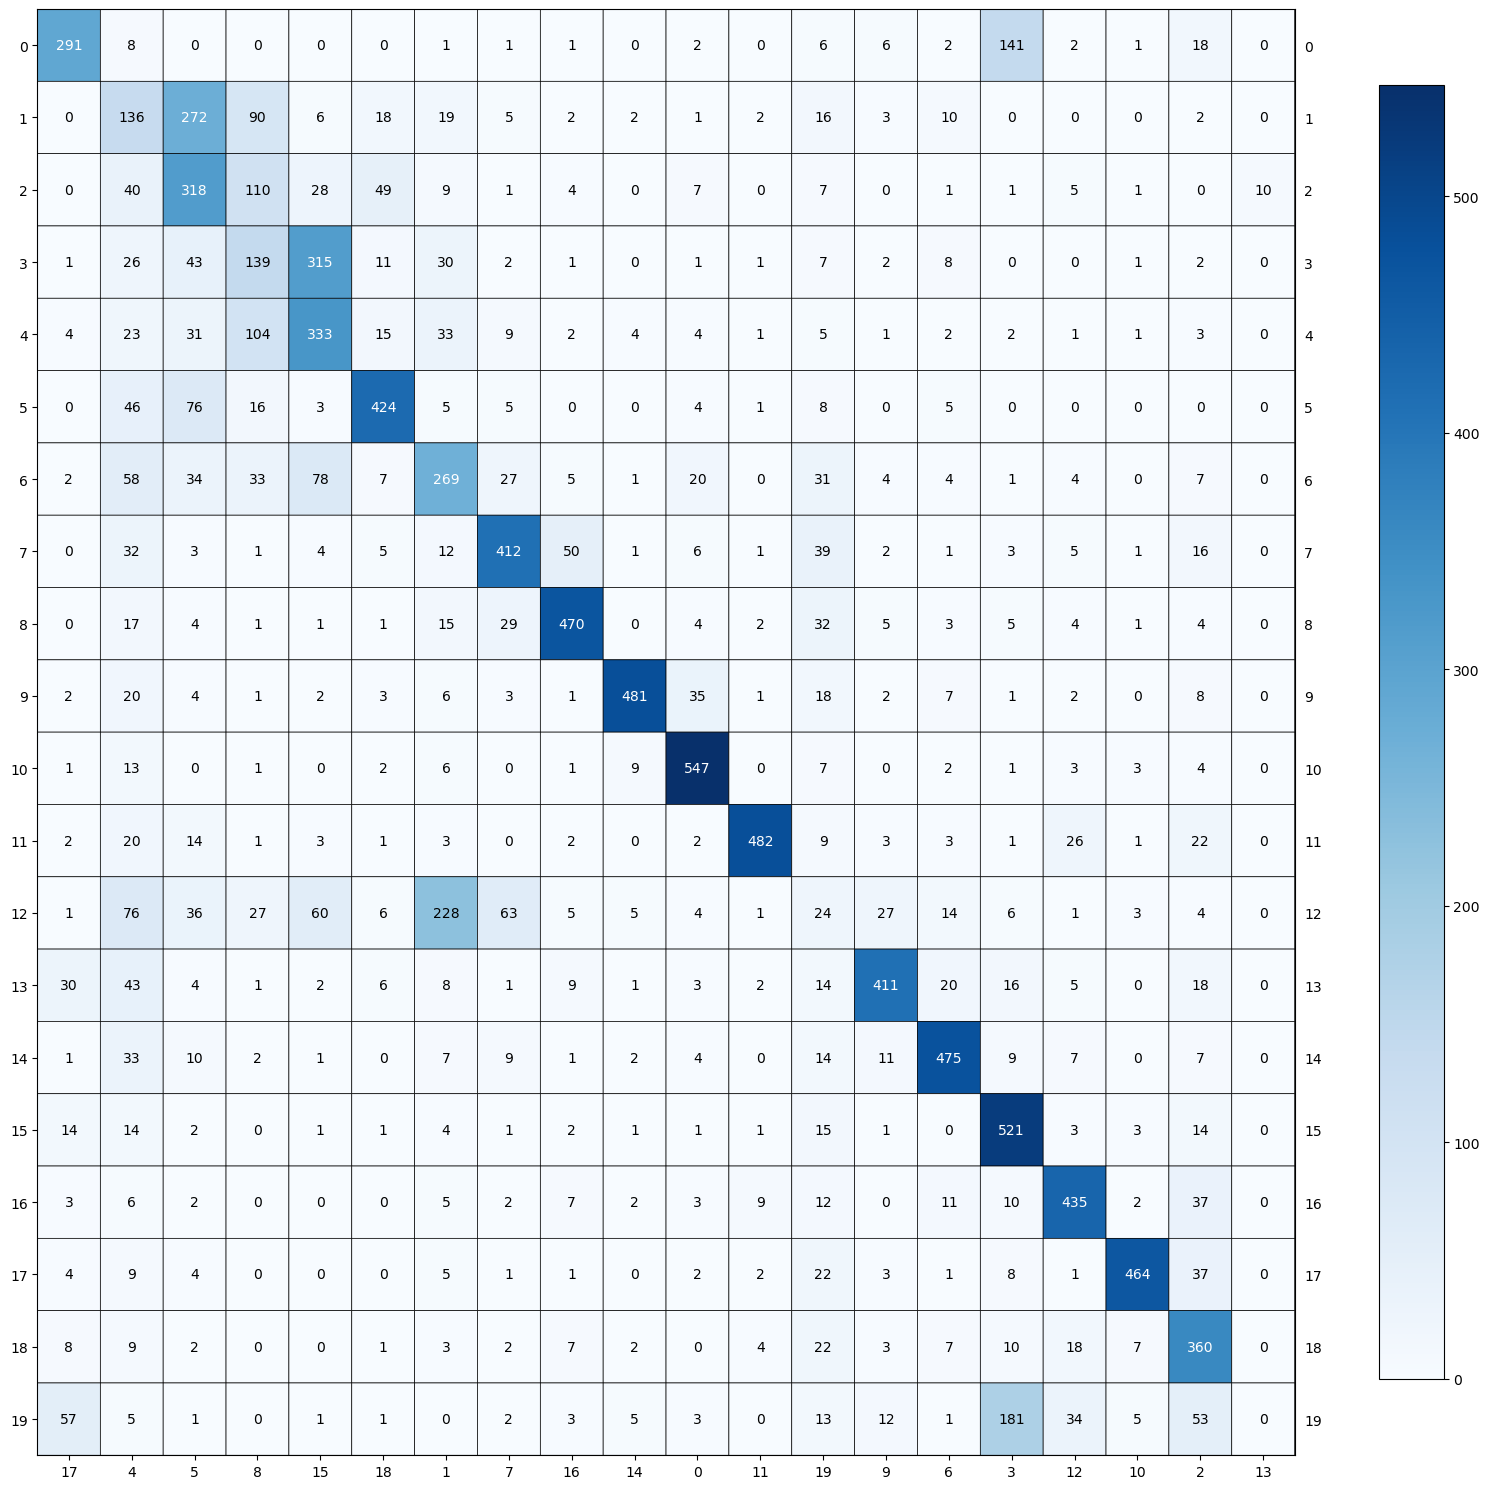

Contingency Matrix: 
 [[  2   1  18 141   8   0   2   1   0   6   1   0   2   0   0   0   1 291
    0   6]
 [  1  19   2   0 136 272  10   5  90   3   0   2   0   0   2   6   2   0
   18  16]
 [  7   9   0   1  40 318   1   1 110   0   1   0   5  10   0  28   4   0
   49   7]
 [  1  30   2   0  26  43   8   2 139   2   1   1   0   0   0 315   1   1
   11   7]
 [  4  33   3   2  23  31   2   9 104   1   1   1   1   0   4 333   2   4
   15   5]
 [  4   5   0   0  46  76   5   5  16   0   0   1   0   0   0   3   0   0
  424   8]
 [ 20 269   7   1  58  34   4  27  33   4   0   0   4   0   1  78   5   2
    7  31]
 [  6  12  16   3  32   3   1 412   1   2   1   1   5   0   1   4  50   0
    5  39]
 [  4  15   4   5  17   4   3  29   1   5   1   2   4   0   0   1 470   0
    1  32]
 [ 35   6   8   1  20   4   7   3   1   2   0   1   2   0 481   2   1   2
    3  18]
 [547   6   4   1  13   0   2   0   1   0   3   0   3   0   9   0   1   1
    2   7]
 [  2   3  22   1  20  14   3   0   1   3  

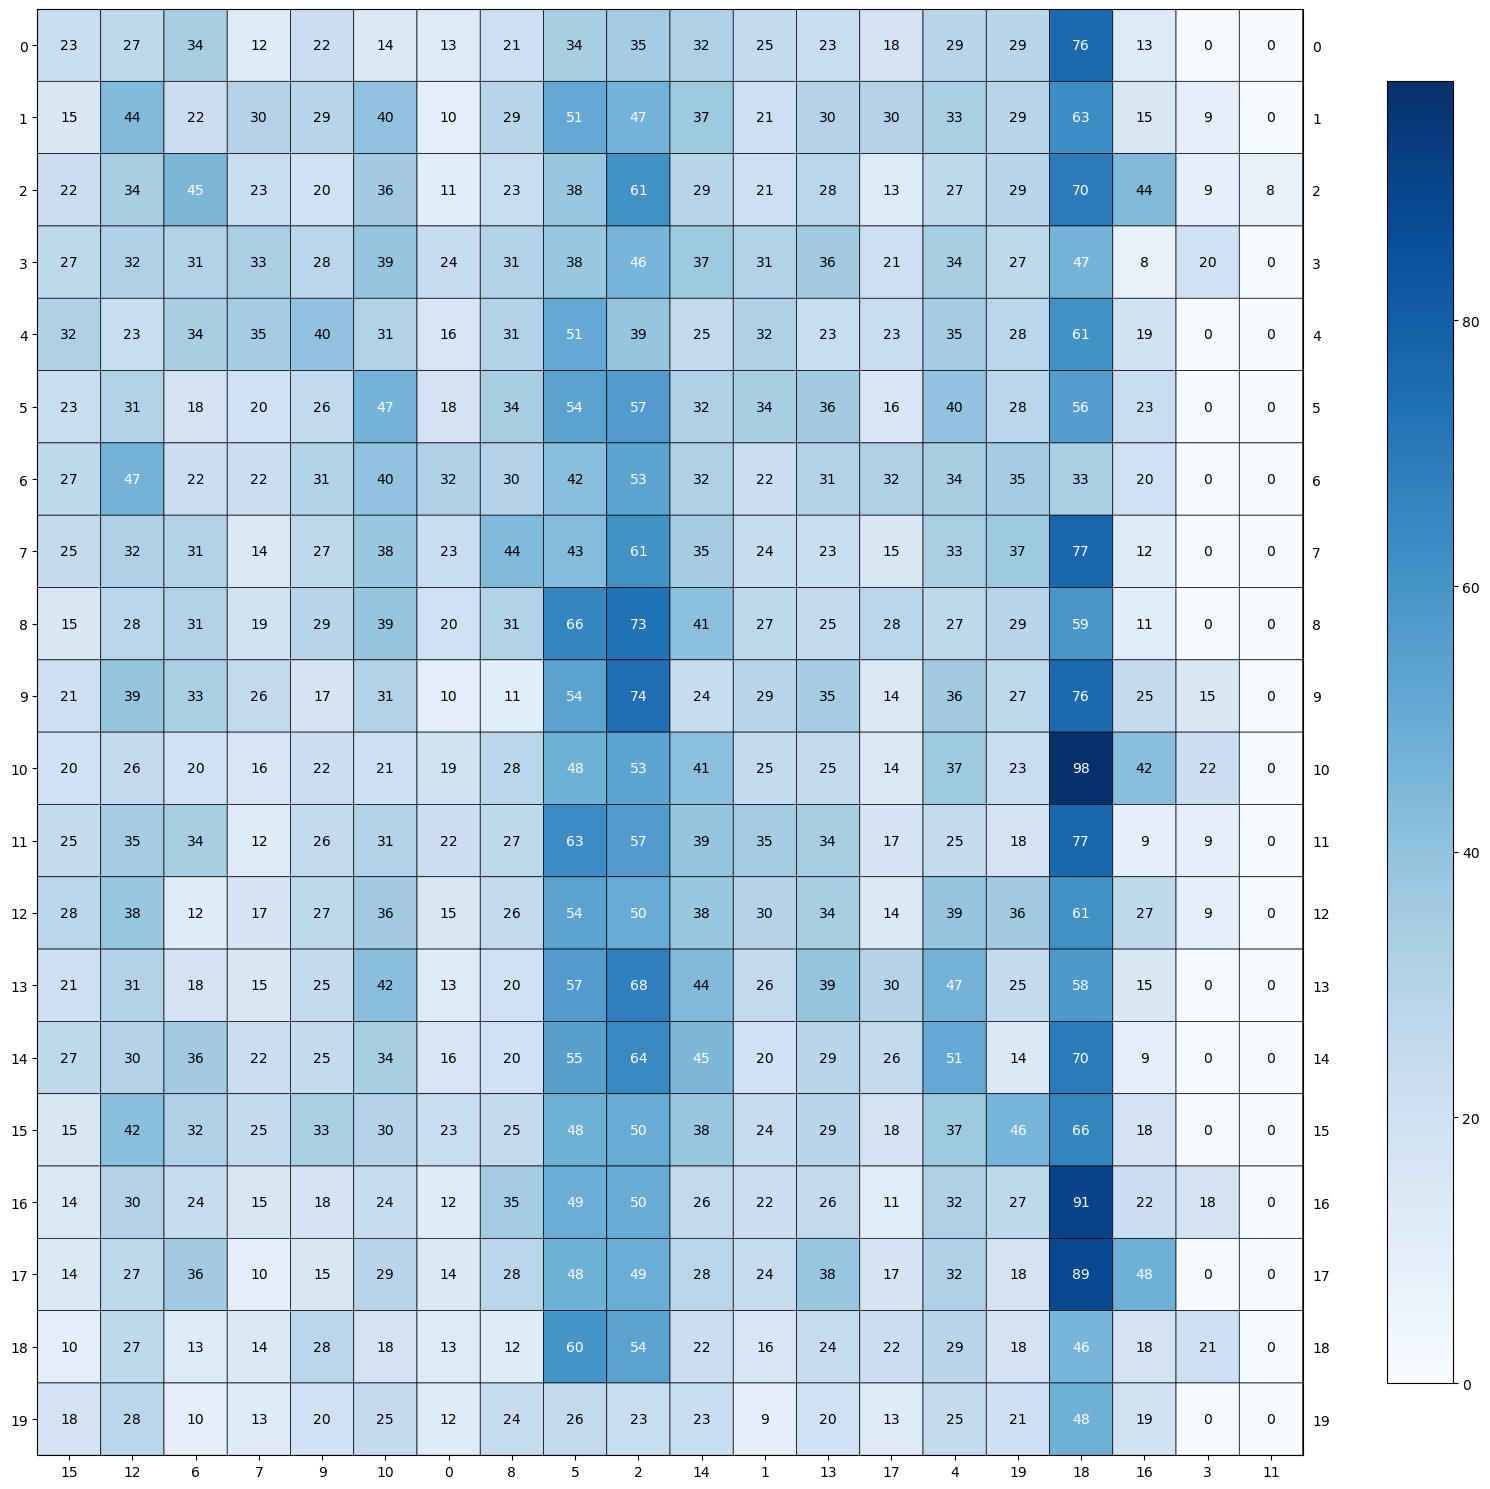

Contingency Matrix: 
 [[13 25 35  0 29 34 34 12 21 22 14  0 27 23 32 23 13 18 76 29]
 [10 21 47  9 33 51 22 30 29 29 40  0 44 30 37 15 15 30 63 29]
 [11 21 61  9 27 38 45 23 23 20 36  8 34 28 29 22 44 13 70 29]
 [24 31 46 20 34 38 31 33 31 28 39  0 32 36 37 27  8 21 47 27]
 [16 32 39  0 35 51 34 35 31 40 31  0 23 23 25 32 19 23 61 28]
 [18 34 57  0 40 54 18 20 34 26 47  0 31 36 32 23 23 16 56 28]
 [32 22 53  0 34 42 22 22 30 31 40  0 47 31 32 27 20 32 33 35]
 [23 24 61  0 33 43 31 14 44 27 38  0 32 23 35 25 12 15 77 37]
 [20 27 73  0 27 66 31 19 31 29 39  0 28 25 41 15 11 28 59 29]
 [10 29 74 15 36 54 33 26 11 17 31  0 39 35 24 21 25 14 76 27]
 [19 25 53 22 37 48 20 16 28 22 21  0 26 25 41 20 42 14 98 23]
 [22 35 57  9 25 63 34 12 27 26 31  0 35 34 39 25  9 17 77 18]
 [15 30 50  9 39 54 12 17 26 27 36  0 38 34 38 28 27 14 61 36]
 [13 26 68  0 47 57 18 15 20 25 42  0 31 39 44 21 15 30 58 25]
 [16 20 64  0 51 55 36 22 20 25 34  0 30 29 45 27  9 26 70 14]
 [23 24 50  0 37 48 32 25 25 33 3

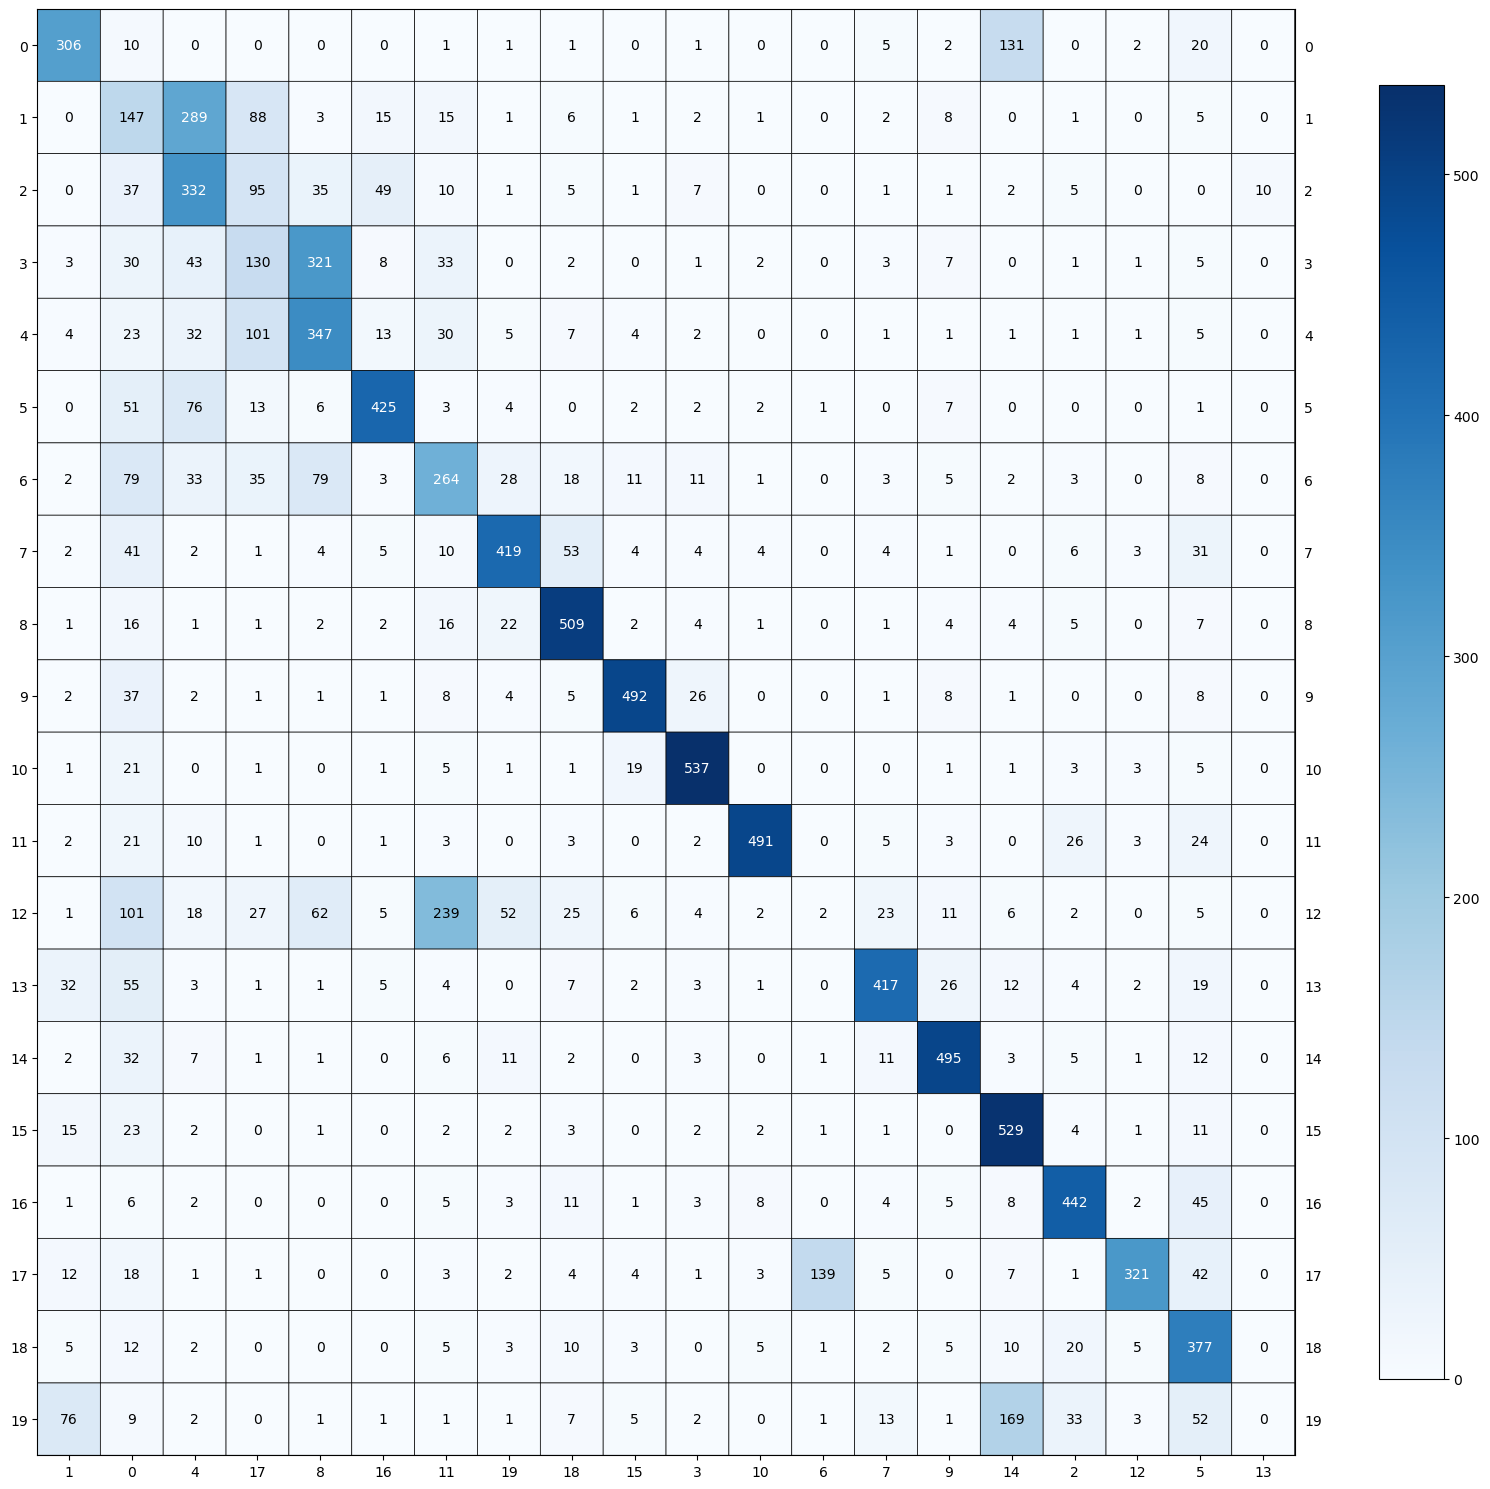

Contingency Matrix: 
 [[ 10 306   0   1   0  20   0   5   0   2   0   1   2   0 131   0   0   0
    1   1]
 [147   0   1   2 289   5   0   2   3   8   1  15   0   0   0   1  15  88
    6   1]
 [ 37   0   5   7 332   0   0   1  35   1   0  10   0  10   2   1  49  95
    5   1]
 [ 30   3   1   1  43   5   0   3 321   7   2  33   1   0   0   0   8 130
    2   0]
 [ 23   4   1   2  32   5   0   1 347   1   0  30   1   0   1   4  13 101
    7   5]
 [ 51   0   0   2  76   1   1   0   6   7   2   3   0   0   0   2 425  13
    0   4]
 [ 79   2   3  11  33   8   0   3  79   5   1 264   0   0   2  11   3  35
   18  28]
 [ 41   2   6   4   2  31   0   4   4   1   4  10   3   0   0   4   5   1
   53 419]
 [ 16   1   5   4   1   7   0   1   2   4   1  16   0   0   4   2   2   1
  509  22]
 [ 37   2   0  26   2   8   0   1   1   8   0   8   0   0   1 492   1   1
    5   4]
 [ 21   1   3 537   0   5   0   0   0   1   0   5   3   0   1  19   1   1
    1   1]
 [ 21   2  26   2  10  24   0   5   0   3 4

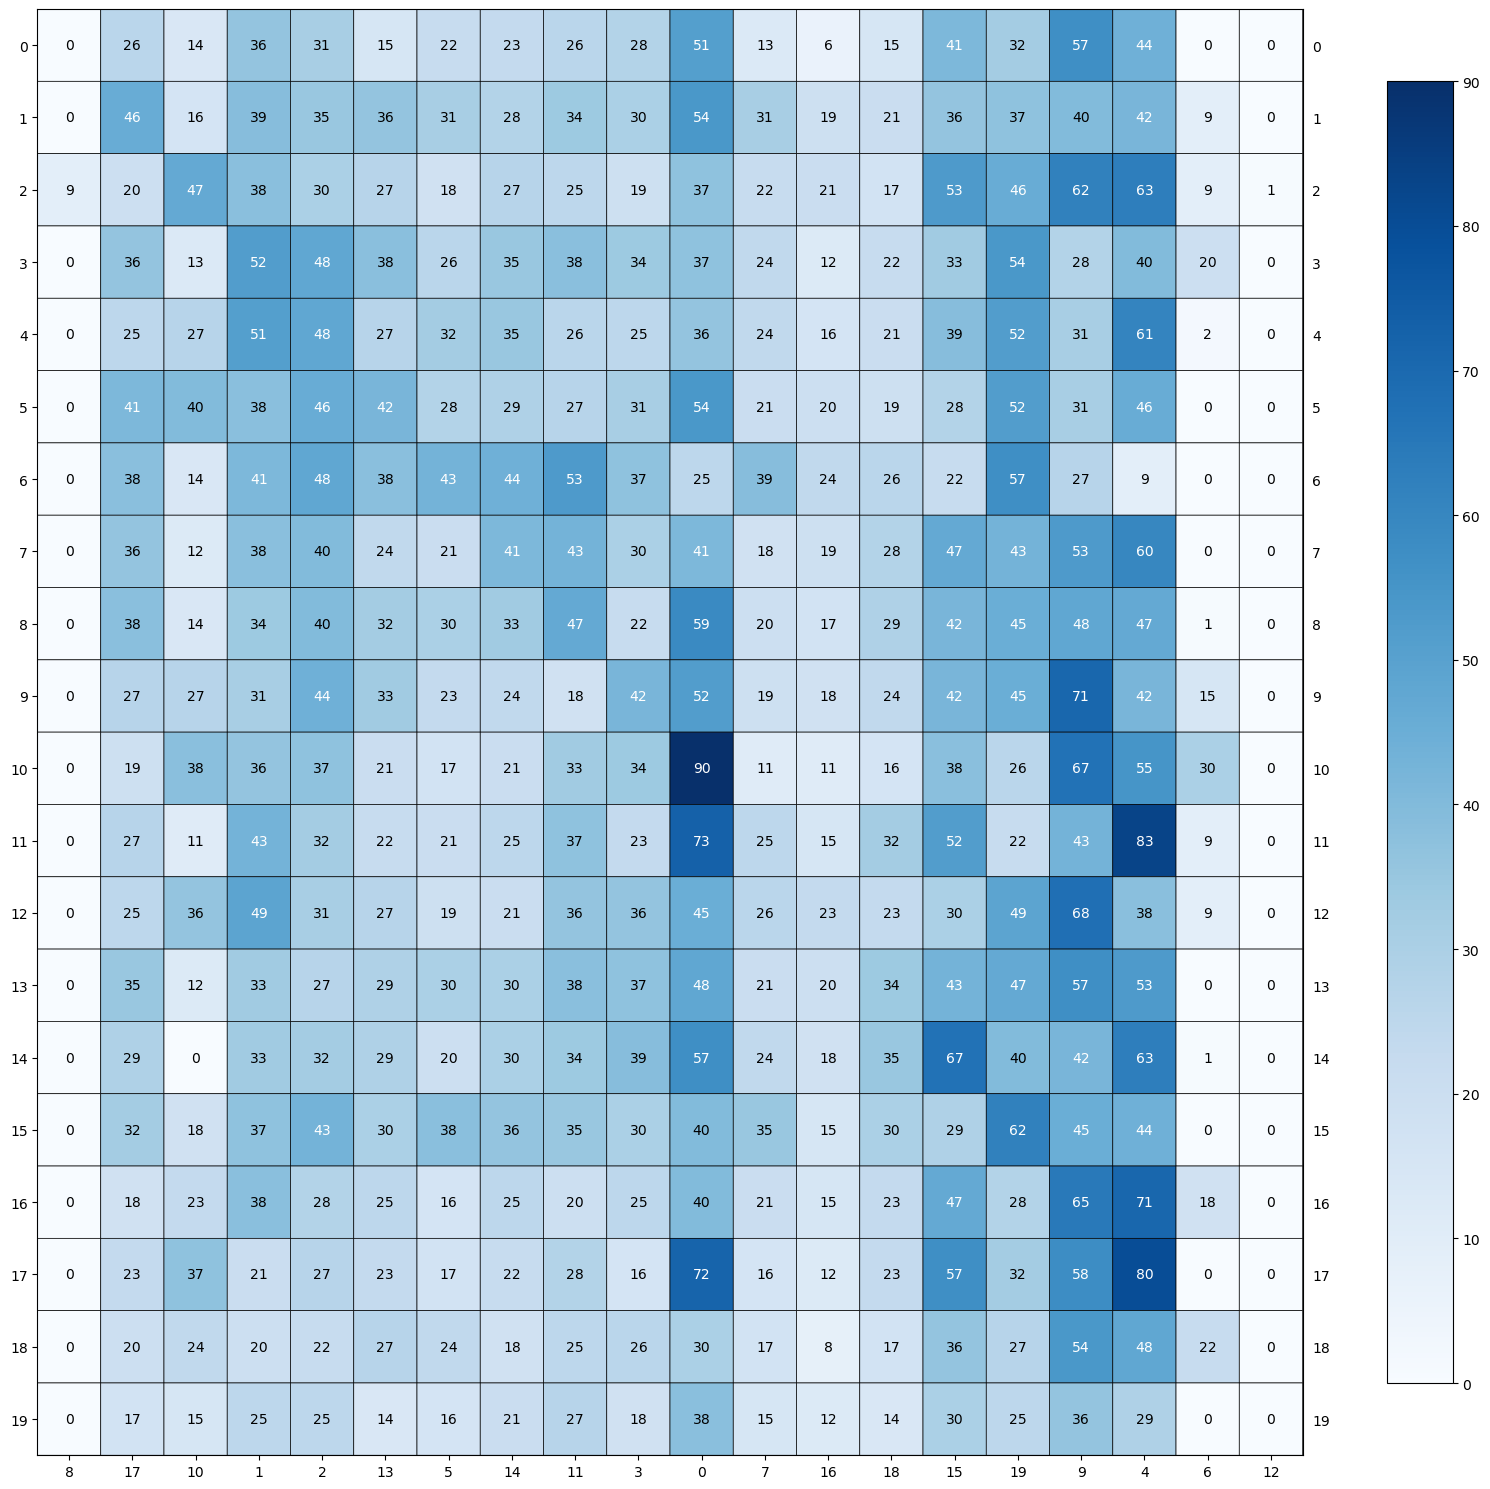

Contingency Matrix: 
 [[51 36 31 28 44 22  0 13  0 57 14 26  0 15 23 41  6 26 15 32]
 [54 39 35 30 42 31  9 31  0 40 16 34  0 36 28 36 19 46 21 37]
 [37 38 30 19 63 18  9 22  9 62 47 25  1 27 27 53 21 20 17 46]
 [37 52 48 34 40 26 20 24  0 28 13 38  0 38 35 33 12 36 22 54]
 [36 51 48 25 61 32  2 24  0 31 27 26  0 27 35 39 16 25 21 52]
 [54 38 46 31 46 28  0 21  0 31 40 27  0 42 29 28 20 41 19 52]
 [25 41 48 37  9 43  0 39  0 27 14 53  0 38 44 22 24 38 26 57]
 [41 38 40 30 60 21  0 18  0 53 12 43  0 24 41 47 19 36 28 43]
 [59 34 40 22 47 30  1 20  0 48 14 47  0 32 33 42 17 38 29 45]
 [52 31 44 42 42 23 15 19  0 71 27 18  0 33 24 42 18 27 24 45]
 [90 36 37 34 55 17 30 11  0 67 38 33  0 21 21 38 11 19 16 26]
 [73 43 32 23 83 21  9 25  0 43 11 37  0 22 25 52 15 27 32 22]
 [45 49 31 36 38 19  9 26  0 68 36 36  0 27 21 30 23 25 23 49]
 [48 33 27 37 53 30  0 21  0 57 12 38  0 29 30 43 20 35 34 47]
 [57 33 32 39 63 20  1 24  0 42  0 34  0 29 30 67 18 29 35 40]
 [40 37 43 30 44 38  0 35  0 45 1

In [25]:
for i, n_comp in enumerate(umap_n_components):
    print(f"Cosine UMAP with n_component = {n_comp} Clustering Measures:")
    umap_cosine_cm = umap_cosine['CM'][i]
    rows, cols = linear_sum_assignment(umap_cosine_cm, maximize=True)
    plot_mat(umap_cosine_cm[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, size=(15,15))
    print(f"Contingency Matrix: \n {umap_cosine_cm}")
    print(f"Homogeneity: {umap_cosine['Homogeneity'][i]}")
    print(f"Completeness: {umap_cosine['Completeness'][i]}")
    print(f"V-measure: {umap_cosine['V-Measure'][i]}")
    print(f"Adjusted Rand Index: {umap_cosine['ARI'][i]}")
    print(f"Adjusted Mutual Information Score: {umap_cosine['AMI'][i]}")
    print()
    print(f"Euclidean UMAP with n_component = {n_comp} Clustering Measures:")
    umap_euclidean_cm = umap_euclidean['CM'][i]
    rows, cols = linear_sum_assignment(umap_euclidean_cm, maximize=True)
    plot_mat(umap_euclidean_cm[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, size=(15,15))
    print(f"Contingency Matrix: \n {umap_euclidean_cm}")
    print(f"Homogeneity: {umap_euclidean['Homogeneity'][i]}")
    print(f"Completeness: {umap_euclidean['Completeness'][i]}")
    print(f"V-measure: {umap_euclidean['V-Measure'][i]}")
    print(f"Adjusted Rand Index: {umap_euclidean['ARI'][i]}")
    print(f"Adjusted Mutual Information Score: {umap_euclidean['AMI'][i]}")
    print()

In [21]:
from sklearn.cluster import AgglomerativeClustering

umap_model = umap.UMAP() # Are there some hyperparams that I have to adjust?
umap_model_transformed = umap_model.fit_transform(newsgroup20_train_tfidf)

ward_clusterer = AgglomerativeClustering(n_clusters=20, linkage='ward')
ward_labels = ward_clusterer.fit_predict(umap_model_transformed)

ward_clusterer_homogeneity = homogeneity_score(newsgroup20_ground_truth_labels, ward_labels)
ward_clusterer_completeness = completeness_score(newsgroup20_ground_truth_labels, ward_labels)
ward_clusterer_v_measure = v_measure_score(newsgroup20_ground_truth_labels, ward_labels)
ward_clusterer_adjusted_rand_index = adjusted_rand_score(newsgroup20_ground_truth_labels, ward_labels)
ward_clusterer_adjusted_mutual_info = adjusted_mutual_info_score(newsgroup20_ground_truth_labels, ward_labels)

print("Ward Clustering Measures:")
print(f"Homogeneity: {ward_clusterer_homogeneity}")
print(f"Completeness: {ward_clusterer_completeness}")
print(f"V-measure: {ward_clusterer_v_measure}")
print(f"Adjusted Rand Index: {ward_clusterer_adjusted_rand_index}")
print(f"Adjusted Mutual Information Score: {ward_clusterer_adjusted_mutual_info}")
print()

single_clusterer = AgglomerativeClustering(n_clusters=20, linkage='single')
single_labels = single_clusterer.fit_predict(umap_model_transformed)

single_clusterer_homogeneity = homogeneity_score(newsgroup20_ground_truth_labels, single_labels)
single_clusterer_completeness = completeness_score(newsgroup20_ground_truth_labels, single_labels)
single_clusterer_v_measure = v_measure_score(newsgroup20_ground_truth_labels, single_labels)
single_clusterer_adjusted_rand_index = adjusted_rand_score(newsgroup20_ground_truth_labels, single_labels)
single_clusterer_adjusted_mutual_info = adjusted_mutual_info_score(newsgroup20_ground_truth_labels, single_labels)

print("Single Clustering Measures:")
print(f"Homogeneity: {single_clusterer_homogeneity}")
print(f"Completeness: {single_clusterer_completeness}")
print(f"V-measure: {single_clusterer_v_measure}")
print(f"Adjusted Rand Index: {single_clusterer_adjusted_rand_index}")
print(f"Adjusted Mutual Information Score: {single_clusterer_adjusted_mutual_info}")

Ward Clustering Measures:
Homogeneity: 0.013248811568862774
Completeness: 0.013997491439248286
V-measure: 0.013612865309481652
Adjusted Rand Index: 0.001787324643282955
Adjusted Mutual Information Score: 0.00808311541237829

Single Clustering Measures:
Homogeneity: 0.014364279418666736
Completeness: 0.3611643283363825
V-measure: 0.027629667733132322
Adjusted Rand Index: 1.7768645987249397e-05
Adjusted Mutual Information Score: 0.01807615257944611


HDBScan Clustering Measures (min_cluster_size = 20):
Homogeneity: 0.009363837360646096
Completeness: 0.2200840818841162
V-measure: 0.017963392783977274
Adjusted Rand Index: 9.380540318622985e-05
Adjusted Mutual Information Score: 0.01493623203989454
Contingency Matrix: 
 [[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0]
 [  4   0   0   0   0 476   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0]
 [ 17   0   0   0   0 567   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0]
 [ 23   0   0   0   0 568   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0]
 [  0   0  21   0   0 569   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0]
 [  0   0   0   0   0 578   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0]
 [  0   0   0   0   0 593   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0]
 [  8   0   0   0   0 577   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0]
 [  6   0   0   

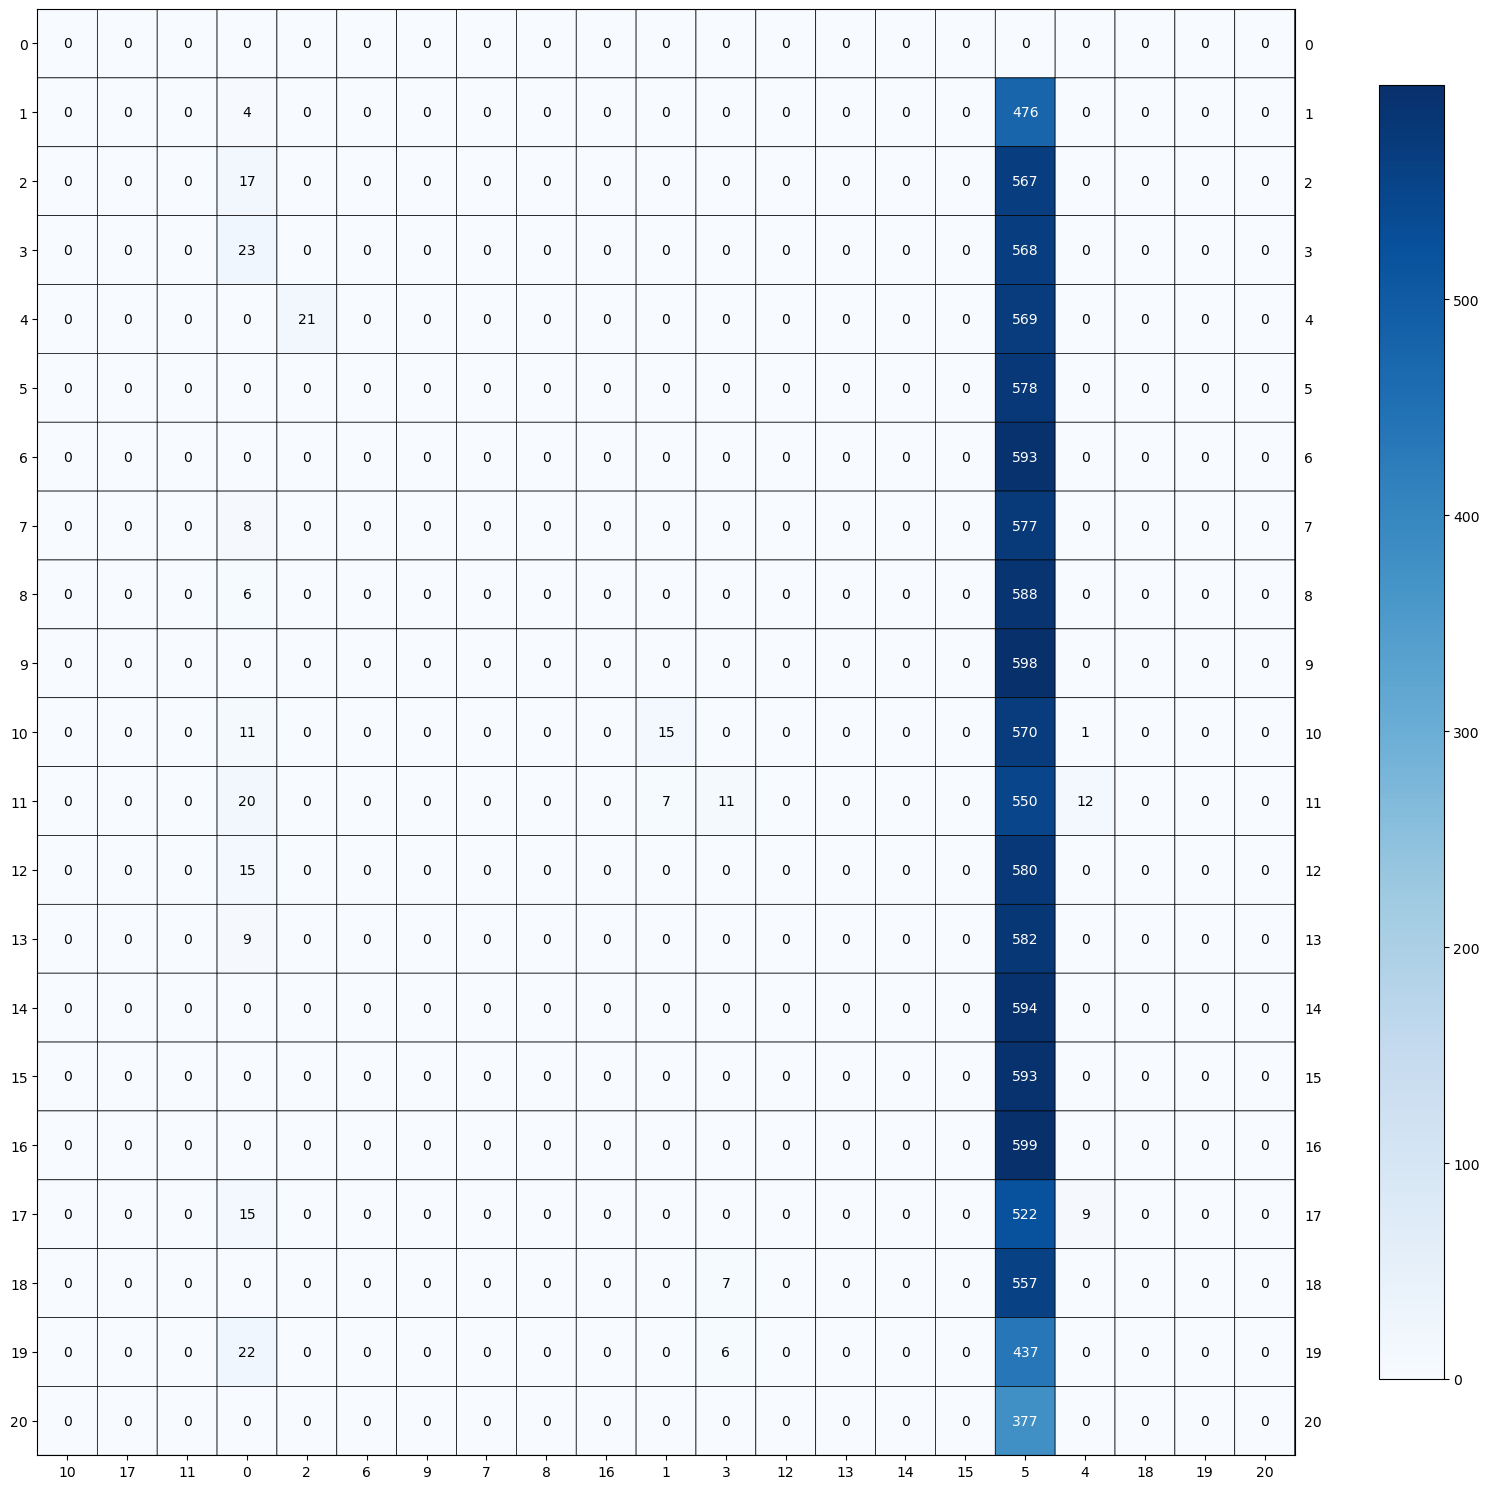


HDBScan Clustering Measures (min_cluster_size = 100):
Homogeneity: 0.0022528526300843368
Completeness: 0.005240098373503491
V-measure: 0.0031510066986946425
Adjusted Rand Index: 0.0005909865083673333
Adjusted Mutual Information Score: 0.001972771180587583
Contingency Matrix: 
 [[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0]
 [223  52  85 120   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0]
 [238  67 115 164   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0]
 [243  72 148 128   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0]
 [255  77 120 138   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0]
 [255  74 106 143   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0]
 [256  89 115 133   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0]
 [211  99 111 164   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0]
 [250  78

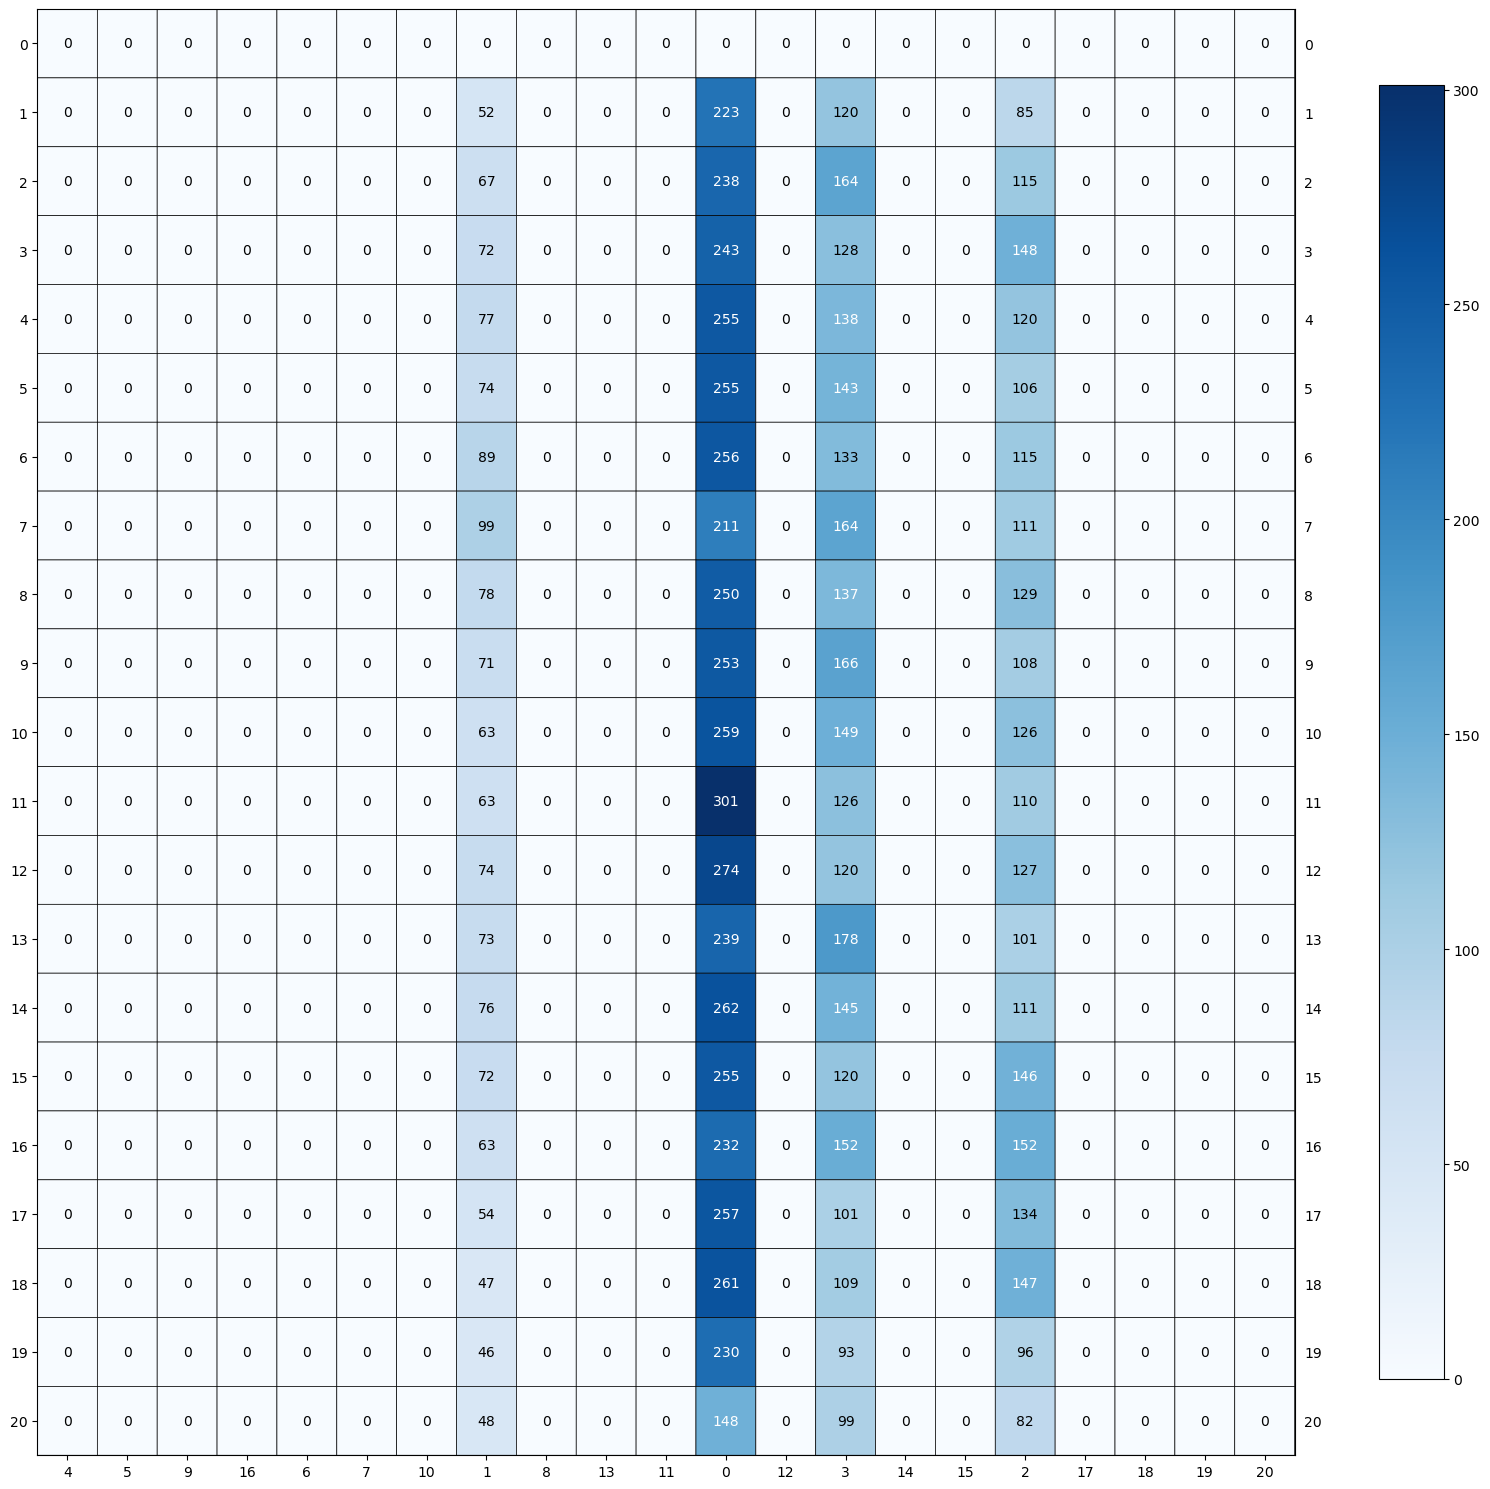


HDBScan Clustering Measures (min_cluster_size = 200):
Homogeneity: 0.0018871494031520403
Completeness: 0.004815199322294475
V-measure: 0.0027115869076241614
Adjusted Rand Index: 0.00022595242144293775
Adjusted Mutual Information Score: 0.0010891177832305801
Contingency Matrix: 
 [[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0]
 [272  17   7  80 104   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0]
 [309  20  18 108 129   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0]
 [323  19  13 130 106   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0]
 [326  25  17 109 113   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0]
 [319  18  14 102 125   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0]
 [335  20  30 105 103   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0]
 [293  22  28 103 139   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0]
 [338  

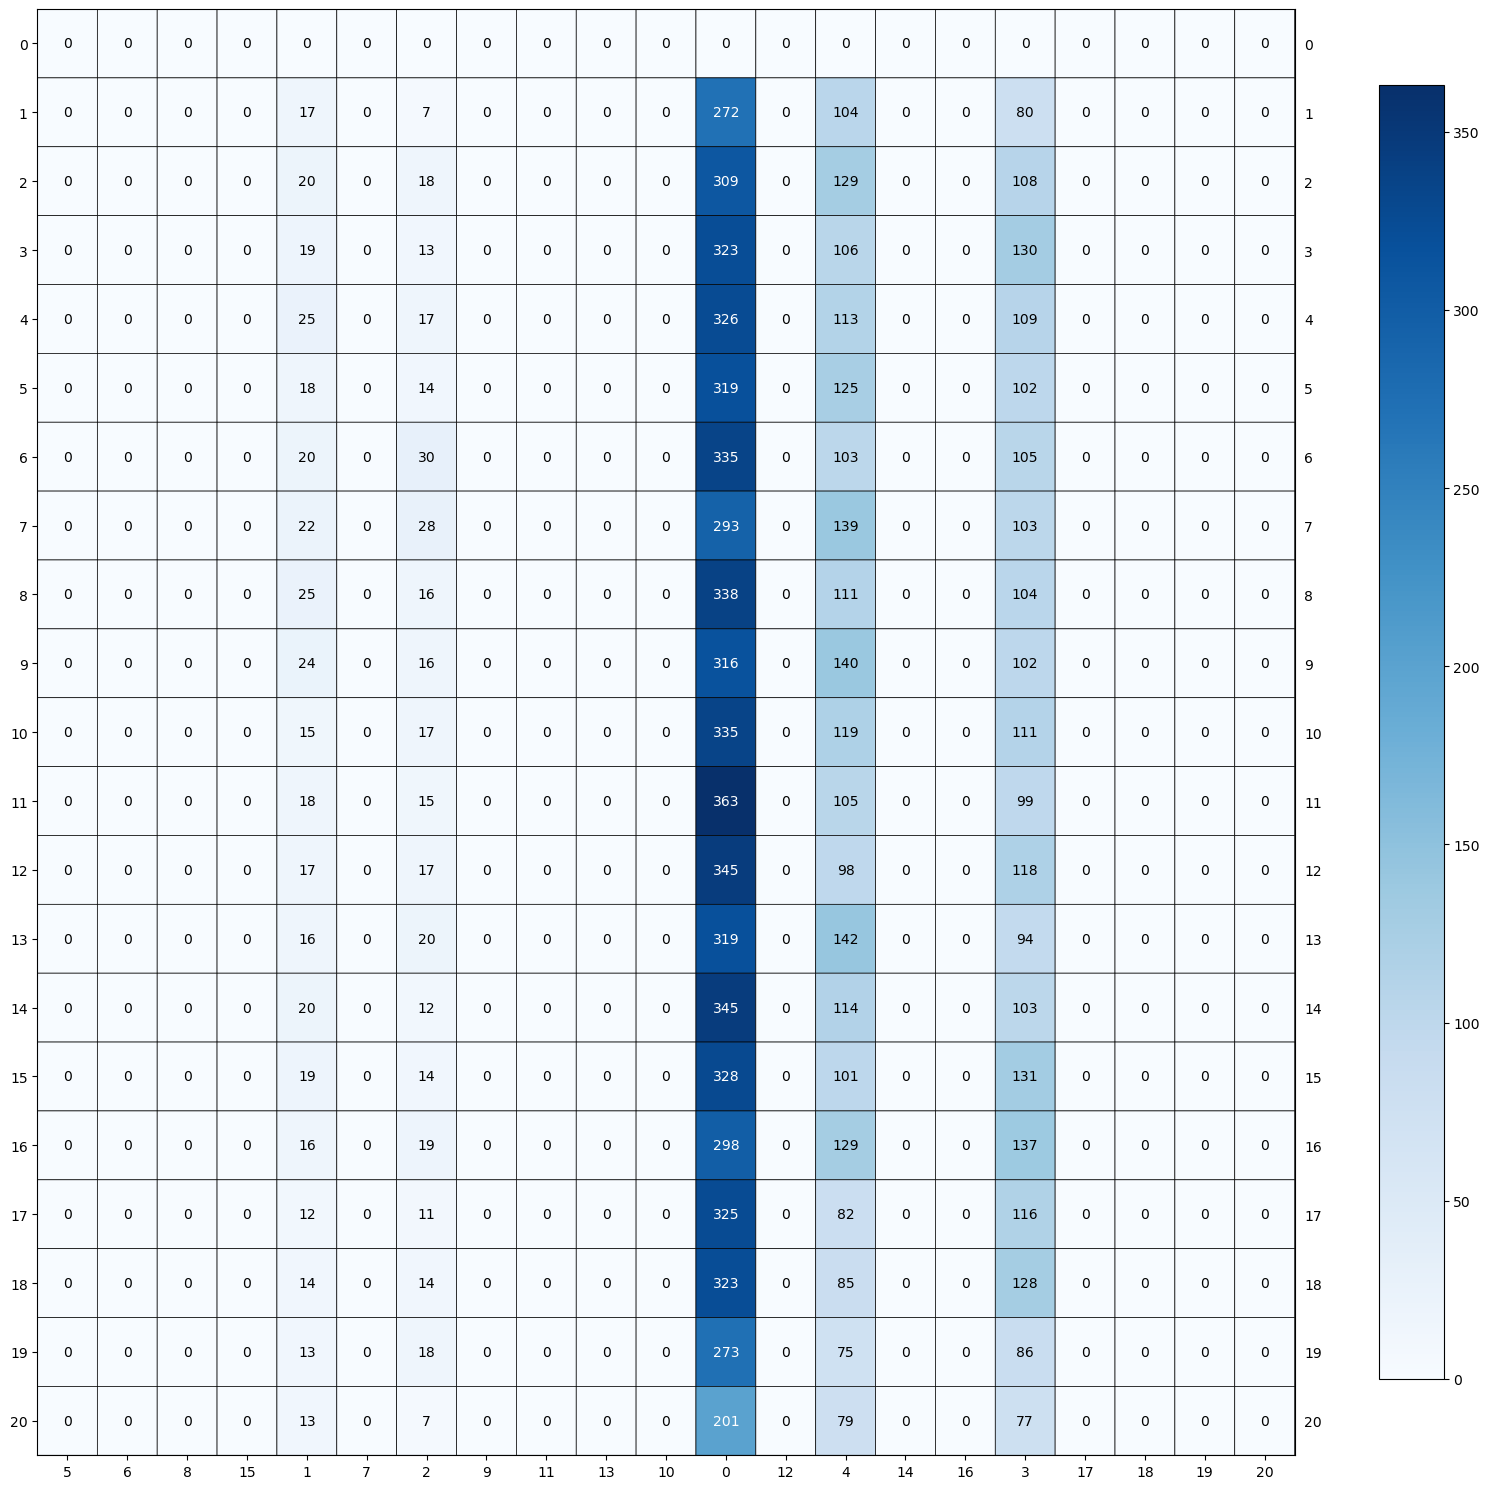

In [22]:
import hdbscan

umap_model = umap.UMAP()
umap_model_transformed = umap_model.fit_transform(newsgroup20_train_tfidf)

min_cluster_sizes = [20, 100, 200]

for min_cluster_size in min_cluster_sizes:
    hdbscan_clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size) # adjust hyperparameters
    hdbscan_labels = hdbscan_clusterer.fit_predict(umap_model_transformed)

    
    hdbscan_clusterer_cm = confusion_matrix(newsgroup20_ground_truth_labels, hdbscan_labels)
    hdbscan_clusterer_homogeneity = homogeneity_score(newsgroup20_ground_truth_labels, hdbscan_labels)
    hdbscan_clusterer_completeness = completeness_score(newsgroup20_ground_truth_labels, hdbscan_labels)
    hdbscan_clusterer_v_measure = v_measure_score(newsgroup20_ground_truth_labels, hdbscan_labels)
    hdbscan_clusterer_adjusted_rand_index = adjusted_rand_score(newsgroup20_ground_truth_labels, hdbscan_labels)
    hdbscan_clusterer_adjusted_mutual_info = adjusted_mutual_info_score(newsgroup20_ground_truth_labels, hdbscan_labels)

    print(f"HDBScan Clustering Measures (min_cluster_size = {min_cluster_size}):")
    print(f"Homogeneity: {hdbscan_clusterer_homogeneity}")
    print(f"Completeness: {hdbscan_clusterer_completeness}")
    print(f"V-measure: {hdbscan_clusterer_v_measure}")
    print(f"Adjusted Rand Index: {hdbscan_clusterer_adjusted_rand_index}")
    print(f"Adjusted Mutual Information Score: {hdbscan_clusterer_adjusted_mutual_info}")
    print(f"Contingency Matrix: \n {hdbscan_clusterer_cm}")
    print(hdbscan_clusterer_cm.shape)
    rows, cols = linear_sum_assignment(hdbscan_clusterer_cm, maximize=True)
    plot_mat(hdbscan_clusterer_cm[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, size=(15,15))
    print()

In [23]:
# best_avg_scores = 0
dim_red_and_clustering_comb = {'None' : {'kmean':{}, 'agglo':{}, 'hdbscan':{}}, 
                                'SVD' : {'kmean':{}, 'agglo':{}, 'hdbscan':{}},
                                'NMF' : {'kmean':{}, 'agglo':{}, 'hdbscan':{}},
                                'UMAP' : {'kmean':{}, 'agglo':{}, 'hdbscan':{}},
                                }

def kmean_clusterting(dim_red, newsgroup20_transformed, newsgroup20_ground_truth_labels):
    k = [10,20,50]
    for num in k:
        newsgroup20_kmeans = KMeans(n_clusters=num, random_state=0, max_iter=1000, n_init=30)
        newsgroup20_kmeans.fit(newsgroup20_transformed)
        newsgroup20_kmeans_labels = newsgroup20_svd_kmeans.labels_
        homogeneity = homogeneity_score(newsgroup20_ground_truth_labels, newsgroup20_kmeans_labels)
        completeness = completeness_score(newsgroup20_ground_truth_labels, newsgroup20_kmeans_labels)
        v_measure = v_measure_score(newsgroup20_ground_truth_labels, newsgroup20_kmeans_labels)
        adjusted_rand_index = adjusted_rand_score(newsgroup20_ground_truth_labels, newsgroup20_kmeans_labels)
        adjusted_mutual_info = adjusted_mutual_info_score(newsgroup20_ground_truth_labels, newsgroup20_kmeans_labels)
        avg_score = (homogeneity + completeness + v_measure + adjusted_rand_index + adjusted_mutual_info)/5
        dim_red_and_clustering_comb[dim_red]['kmean'][num] = avg_score

def agglomerative_clusterting(dim_red, newsgroup20_transformed, newsgroup20_ground_truth_labels):
    agglo_clusterer = AgglomerativeClustering(n_clusters=20, linkage='ward') 
    agglo_labels = agglo_clusterer.fit_predict(newsgroup20_transformed)
    homogeneity = homogeneity_score(newsgroup20_ground_truth_labels, agglo_labels)
    completeness = completeness_score(newsgroup20_ground_truth_labels, agglo_labels)
    v_measure = v_measure_score(newsgroup20_ground_truth_labels, agglo_labels)
    adjusted_rand_index = adjusted_rand_score(newsgroup20_ground_truth_labels, agglo_labels)
    adjusted_mutual_info = adjusted_mutual_info_score(newsgroup20_ground_truth_labels, agglo_labels)
    avg_score = (homogeneity + completeness + v_measure + adjusted_rand_index + adjusted_mutual_info)/5
    dim_red_and_clustering_comb[dim_red]['agglo'][20] = avg_score

def hdbscan_clusterting(dim_red, newsgroup20_transformed, newsgroup20_ground_truth_labels):
    min_cluster_size = [100,200]
    for num in min_cluster_size:
        hdbscan_clusterer = hdbscan.HDBSCAN(min_cluster_size=num)
        hdbscan_labels = hdbscan_clusterer.fit_predict(newsgroup20_transformed)
        homogeneity = homogeneity_score(newsgroup20_ground_truth_labels, hdbscan_labels)
        completeness = completeness_score(newsgroup20_ground_truth_labels, hdbscan_labels)
        v_measure = v_measure_score(newsgroup20_ground_truth_labels, hdbscan_labels)
        adjusted_rand_index = adjusted_rand_score(newsgroup20_ground_truth_labels, hdbscan_labels)
        adjusted_mutual_info = adjusted_mutual_info_score(newsgroup20_ground_truth_labels, hdbscan_labels)
        avg_score = (homogeneity + completeness + v_measure + adjusted_rand_index + adjusted_mutual_info)/5
        dim_red_and_clustering_comb[dim_red]['hdbscan'][num] = avg_score
    
#None   
kmean_clusterting('None', newsgroup20_train_tfidf.toarray(), newsgroup20_ground_truth_labels)
agglomerative_clusterting('None', newsgroup20_train_tfidf.toarray(), newsgroup20_ground_truth_labels)
hdbscan_clusterting('None', newsgroup20_train_tfidf.toarray(), newsgroup20_ground_truth_labels)

r_and_n_comp = [5,20,200]
for num in r_and_n_comp:
    # SVD
    newsgroup20_svd = TruncatedSVD(n_components=num, random_state=0)
    newsgroup20_svd_transformed = newsgroup20_svd.fit_transform(newsgroup20_train_tfidf)
    kmean_clusterting('SVD', newsgroup20_svd_transformed, newsgroup20_ground_truth_labels)
    agglomerative_clusterting('SVD', newsgroup20_svd_transformed, newsgroup20_ground_truth_labels)
    hdbscan_clusterting('SVD', newsgroup20_svd_transformed, newsgroup20_ground_truth_labels)
    
    # NMF
    newsgroup20_nmf = NMF(n_components=num, max_iter=1000, init='random', random_state=0)
    newsgroup20_nmf_transformed = newsgroup20_nmf.fit_transform(newsgroup20_train_tfidf)
    kmean_clusterting('NMF', newsgroup20_nmf_transformed, newsgroup20_ground_truth_labels)
    agglomerative_clusterting('NMF', newsgroup20_nmf_transformed, newsgroup20_ground_truth_labels)
    hdbscan_clusterting('NMF', newsgroup20_nmf_transformed, newsgroup20_ground_truth_labels)

    newsgroup20_umap = umap.UMAP(n_components=num)
    newsgroup20_umap_transformed = newsgroup20_umap.fit_transform(newsgroup20_train_tfidf)
    kmean_clusterting('UMAP', newsgroup20_umap_transformed, newsgroup20_ground_truth_labels)
    agglomerative_clusterting('UMAP', newsgroup20_umap_transformed, newsgroup20_ground_truth_labels)
    hdbscan_clusterting('UMAP', newsgroup20_umap_transformed, newsgroup20_ground_truth_labels)

print(dim_red_and_clustering_comb)
    

{'None': {'kmean': {10: 0.31634736393460405, 20: 0.31634736393460405, 50: 0.31634736393460405}, 'agglo': {20: 0.36960007528083527}, 'hdbscan': {100: 0.2, 200: 0.2}}, 'SVD': {'kmean': {10: 0.31634736393460405, 20: 0.31634736393460405, 50: 0.31634736393460405}, 'agglo': {20: 0.33616216587869163}, 'hdbscan': {100: 0.2, 200: 0.2}}, 'NMF': {'kmean': {10: 0.31634736393460405, 20: 0.31634736393460405, 50: 0.31634736393460405}, 'agglo': {20: 0.18694528574285818}, 'hdbscan': {100: 0.2, 200: 0.2}}, 'UMAP': {'kmean': {10: 0.31634736393460405, 20: 0.31634736393460405, 50: 0.31634736393460405}, 'agglo': {20: 0.013596060188171496}, 'hdbscan': {100: 0.007802540854748778, 200: 0.0029273012865734293}}}
